In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import itertools
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool

from graph_generation import GenerateGraph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding
import experiments
from experiments import (Experiments, experiment_node_embedding, 
                          all_seeds)

from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, 
                        plot_node_emb_1D_perclass, plot_node_emb_nD_perclass, plot_node_emb_3D, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_3D, plot_graph_emb_1D_continuousregression, 
                        plot_data_degree_sequence, 
                        plot_corr_epoch, plot_ripetizioni_stesso_trial)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect
from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations, open_df_results
from plot_model import plot_model

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
import tensorflow as tf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params
init_params()
#pd.set_option('display.height', 500)

rootsave = Path("output_plots/")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

# Regressione

## Distribuzione discreta - ultimi layer Linear

In [2]:
config_file = "configurations/regression1.yml"

In [9]:
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)

In [10]:
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 14.965 p=0.05
Mean connectivity for each node: 89.672 p=0.3
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 13.94it/s]


Tempo impiegato: 28.751351594924927


100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [06:22<00:00,  7.83it/s]


test accuracy finale: 0


### Display the model

aten::new_zeros %index.19 : Long(54000, strides=[1], requires_grad=0, device=cuda:0) = aten::new_zeros(%795, %604, %605, %606, %607, %608) # /home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/nn/aggr/base.py:56:0



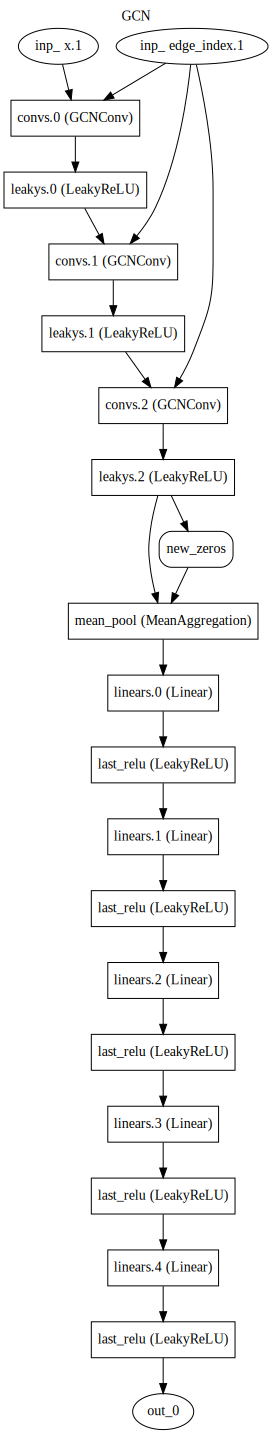

In [7]:
batch = xp.trainer.dataset.sample_dummy_data()
d = plot_model(xp.trainer.model, batch)
d

### Inspect Embedding feature arrays

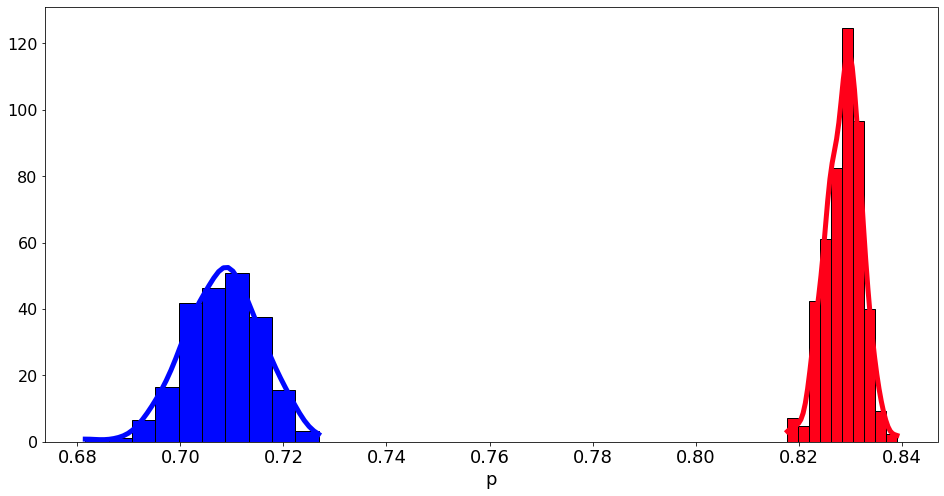

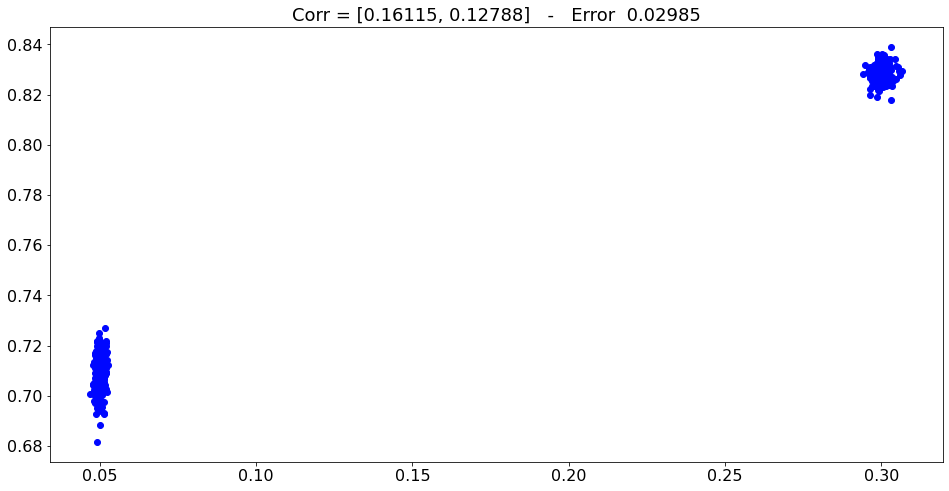

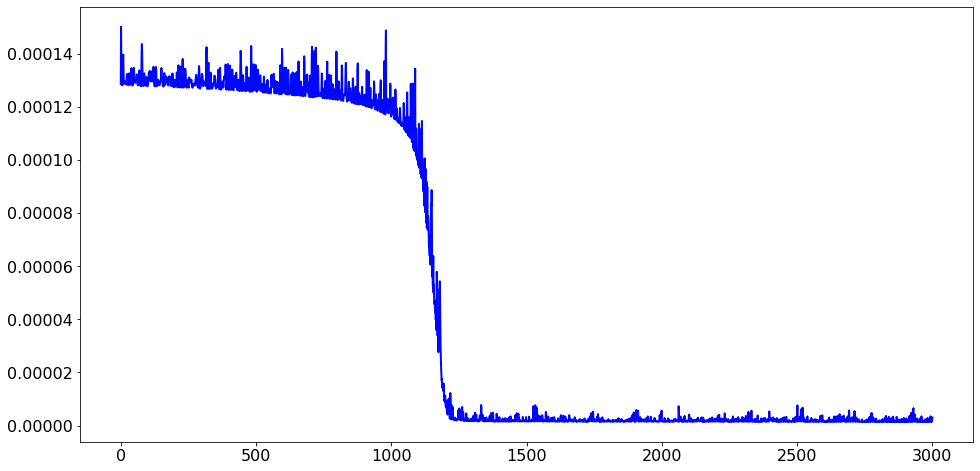

In [11]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
get_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list);

##### $\rightarrow \rightarrow \rightarrow$ L'embedding non ricalca più il valore di p, come è normale aspettarsi, perché ci sono i livelli Linear, ma il training viene comunque bene

## freeze GCN layers

In [4]:
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 14.963 p=0.05
Mean connectivity for each node: 89.712 p=0.3
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.67it/s]


Tempo impiegato: 29.338005542755127


100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [05:40<00:00,  8.82it/s]


test accuracy finale: 0


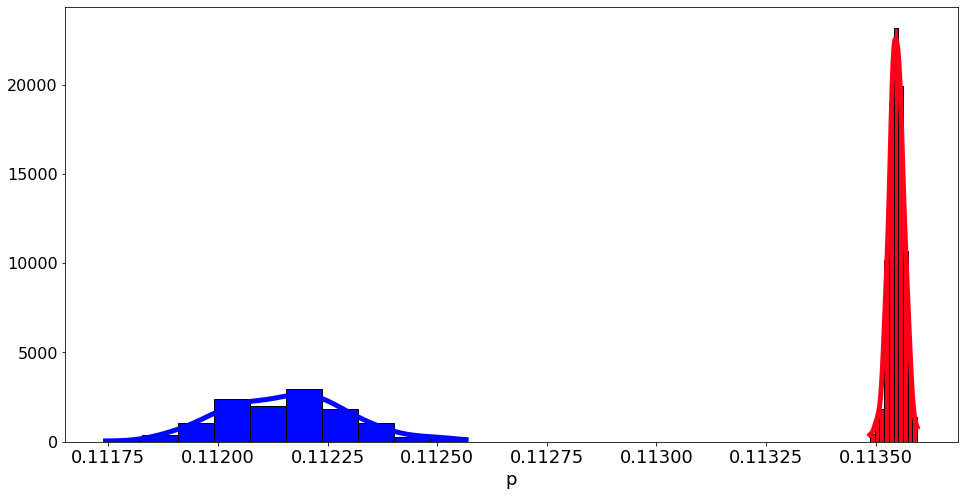

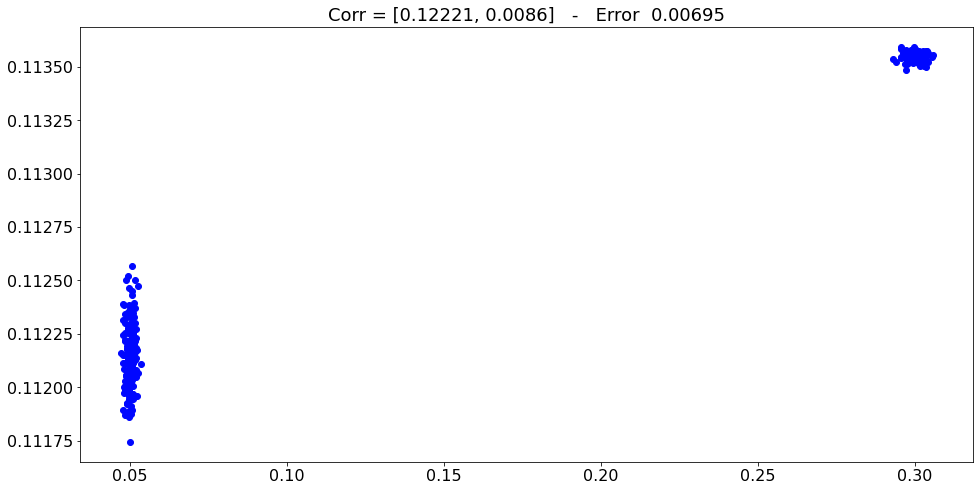

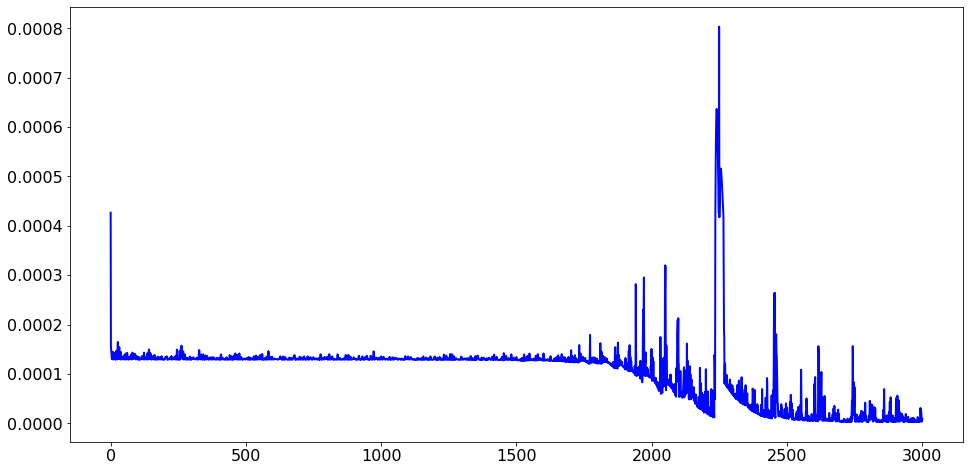

In [5]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list);

##### $\rightarrow \rightarrow \rightarrow$ Quindi vediamo che con la GCN freezed, gli embedding iniziali sono sufficienti a far convergere il modello


## Distribuzione discreta - senza ultimo layer Denso

In [5]:
config_file = "configurations/regression2.yml"

xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 14.956 p=0.05
Mean connectivity for each node: 89.62 p=0.3
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 14.01it/s]


Tempo impiegato: 28.628684759140015


100%|███████████████████████████████████████████████████████████████████████| 800/800 [01:00<00:00, 13.28it/s]


test accuracy finale: 0


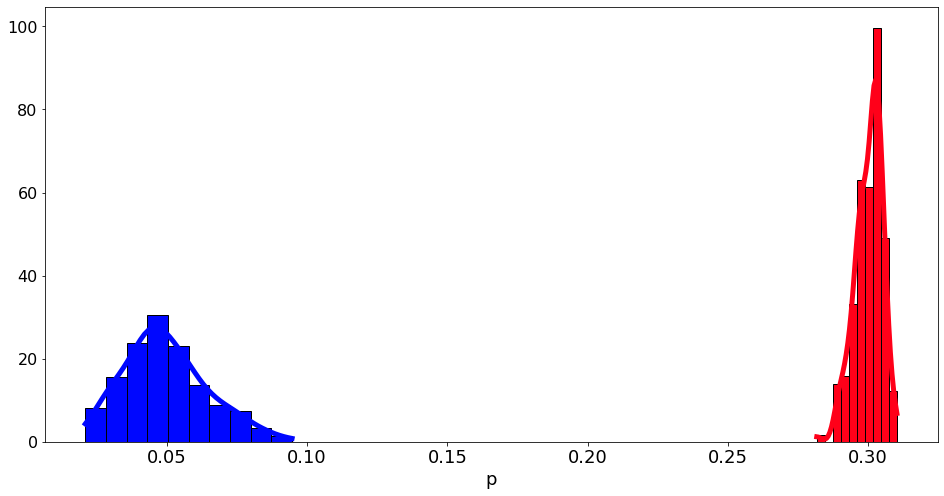

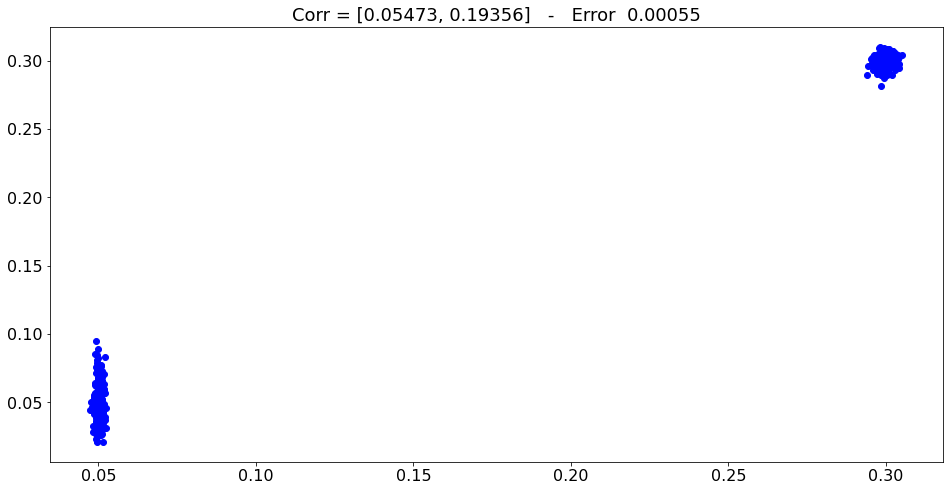

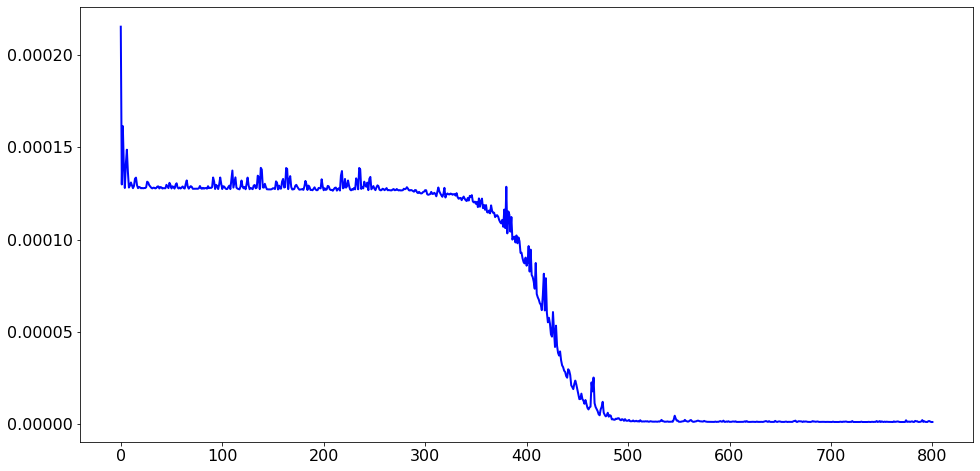

In [9]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list);

In [ ]:
provare con più di due classi, far vedere che quando aggiungo le classi come vanno i picchi

## Distribuzione continua - ultimo layer Denso

### Embedding 1D

In [36]:
config_file = "configurations/regression3.yml"

xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 600/600 [01:17<00:00,  7.76it/s]


Tempo impiegato: 77.5006046295166


100%|█████████████████████████████████████████████████████████████████████| 3500/3500 [12:24<00:00,  4.70it/s]


test accuracy finale: 0


In [12]:
embedding_class.graph_correlation_per_class

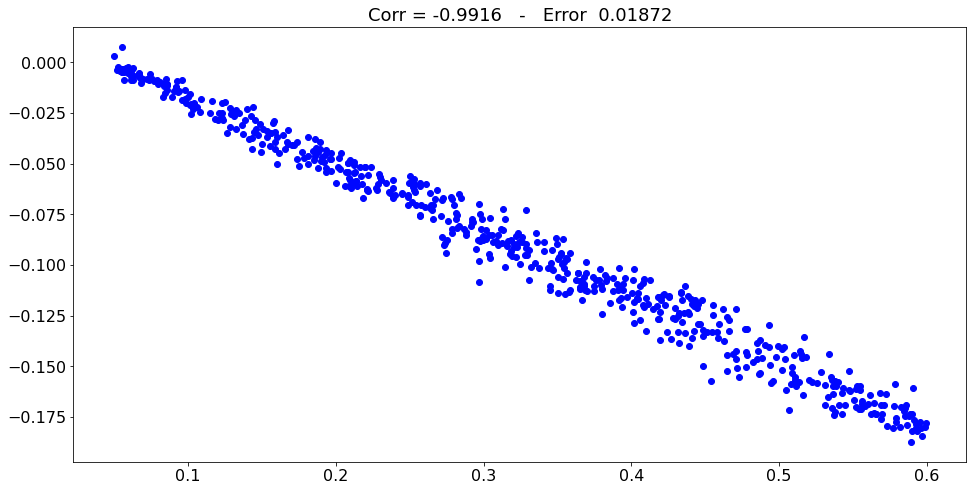

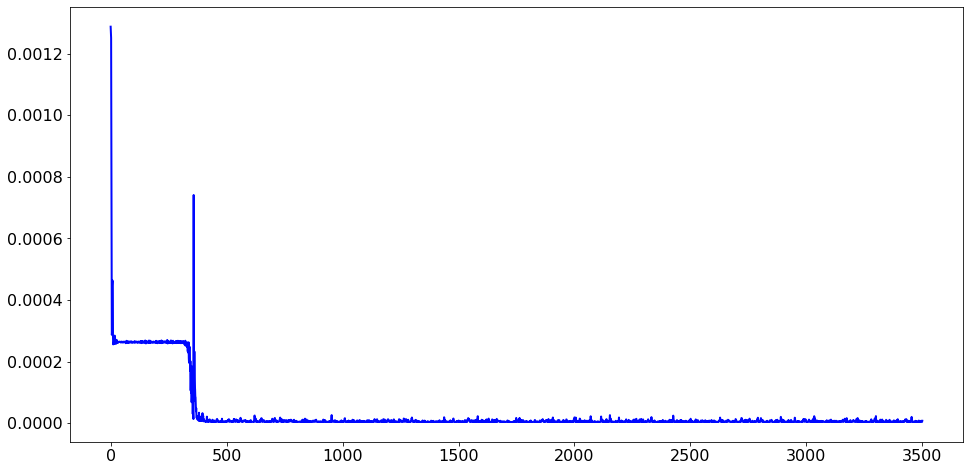

In [37]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list); #plot_wo_outliers

In [33]:
# da correggere
#plot_graph_emb_1D_continuousregression(embedding_class, xp.trainer.config_class)

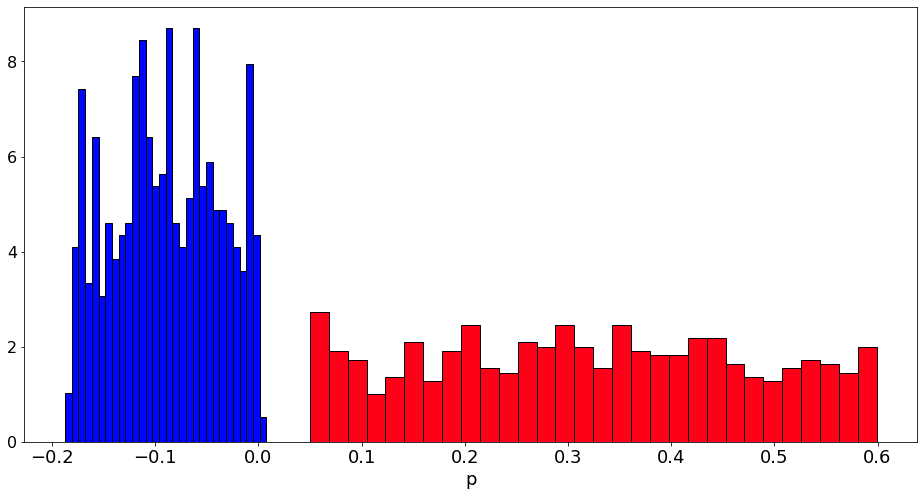

In [38]:
emb = embedding_class.graph_embedding_array.flatten()
lab = embedding_class.embedding_labels
plot_dim1([emb, lab], bins=30, want_kde=False)

##### $ \rightarrow \rightarrow \rightarrow $ Con i layer Linear l'embedding non ricalca i valori scalari di p

### Embedding 3D

In [33]:
# ho impostato l'ultimo layer GCN a 3
config_file = "configurations/regression3.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:03<00:00,  7.83it/s]


Tempo impiegato: 63.96457767486572


100%|█████████████████████████████████████████████████████████████████████| 3500/3500 [14:22<00:00,  4.06it/s]

test accuracy finale: 0


In [34]:
embedding_class = xp.embedding()

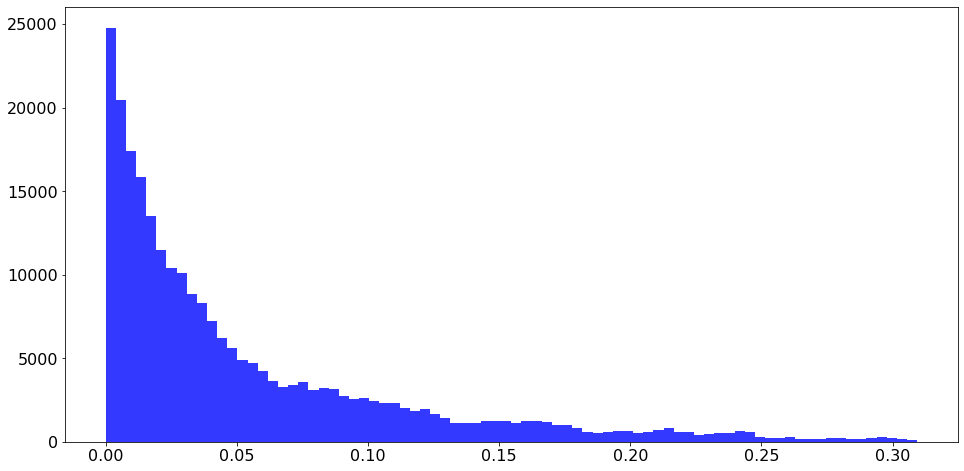

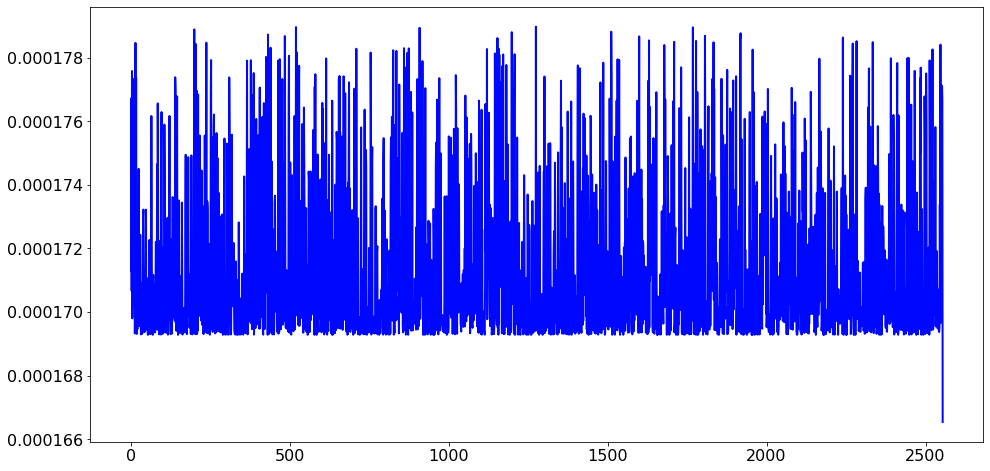

In [35]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list)); 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


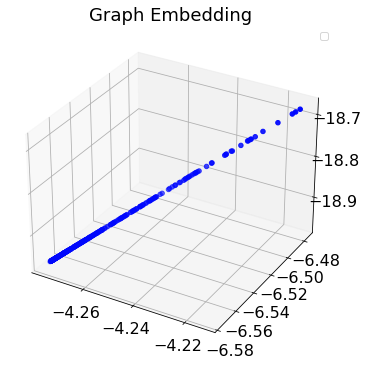

In [36]:
plot_graph_emb_3D(embedding_class.graph_embedding_array, xp.trainer.config_class)

## Distribuzione continua - senza ultimo layer Denso

In [2]:
config_file = "configurations/regression4.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.60it/s]


Tempo impiegato: 65.91834568977356


100%|█████████████████████████████████████████████████████████████████████| 2000/2000 [07:50<00:00,  4.25it/s]


test accuracy finale: 0


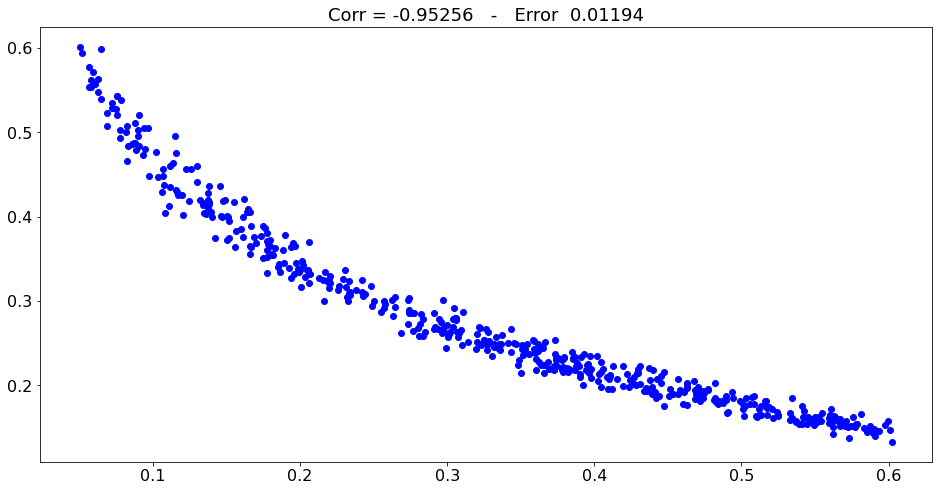

(0.0, 0.001)

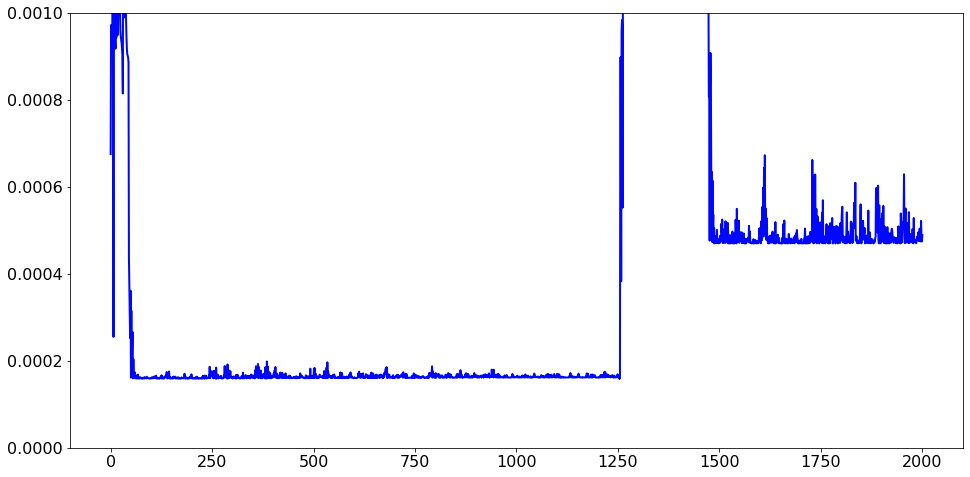

In [7]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list); #array_wo_outliers
plt.ylim(0,0.001)

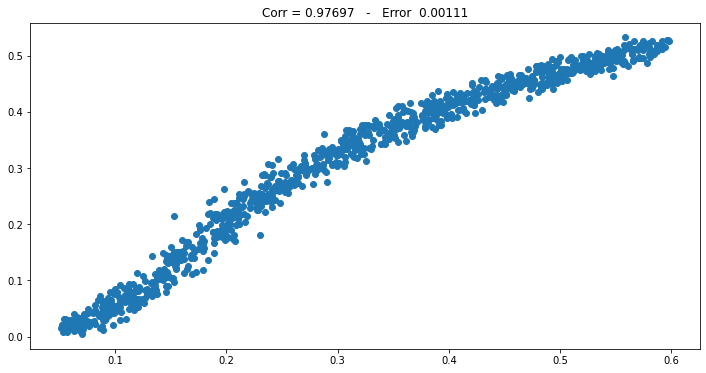

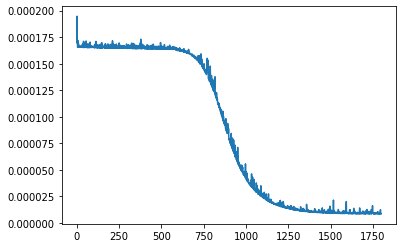

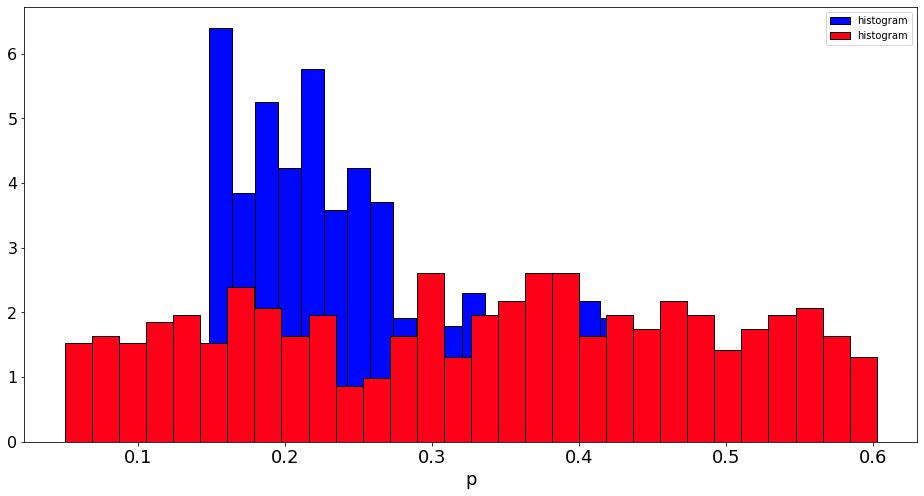

In [4]:
emb = embedding_class.graph_embedding_array.flatten()
lab = embedding_class.embedding_labels
plot_dim1([emb, lab], bins=30, want_kde=False)

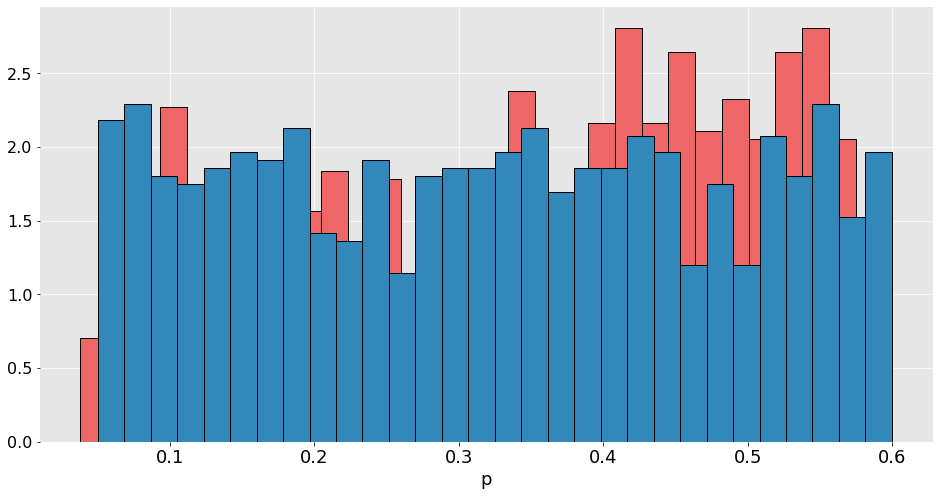

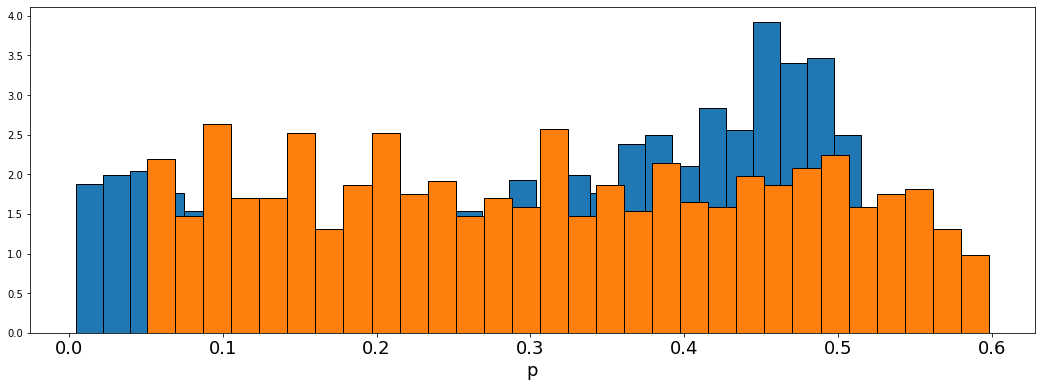

# Classificazione

## 2 classi - ultimo layer Linear  - Freezed

In [2]:
config_file = "configurations/classification1.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()

<class 'str'>
Generating dataset...
Mean connectivity for each node: 14.939 p=0.05
Mean connectivity for each node: 29.906 p=0.1
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.07it/s]


Tempo impiegato: 69.02721071243286


100%|██████████████████████████████████████████████| 20000/20000 [1:39:19<00:00,  3.36it/s]

test accuracy finale: 1.0


In [3]:
embedding_class = xp.embedding()

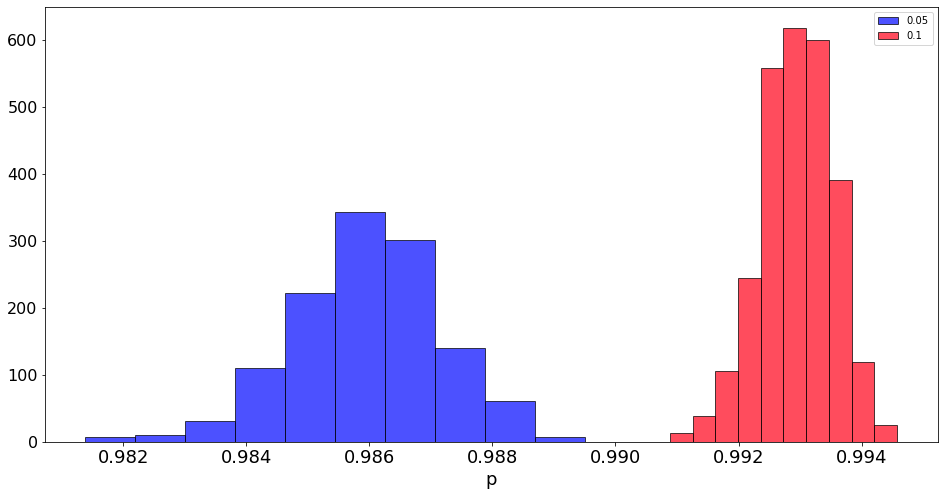

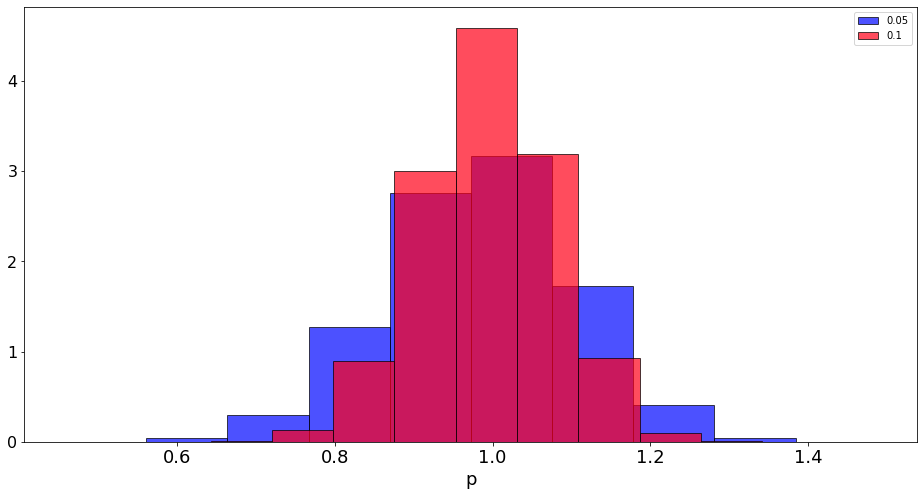

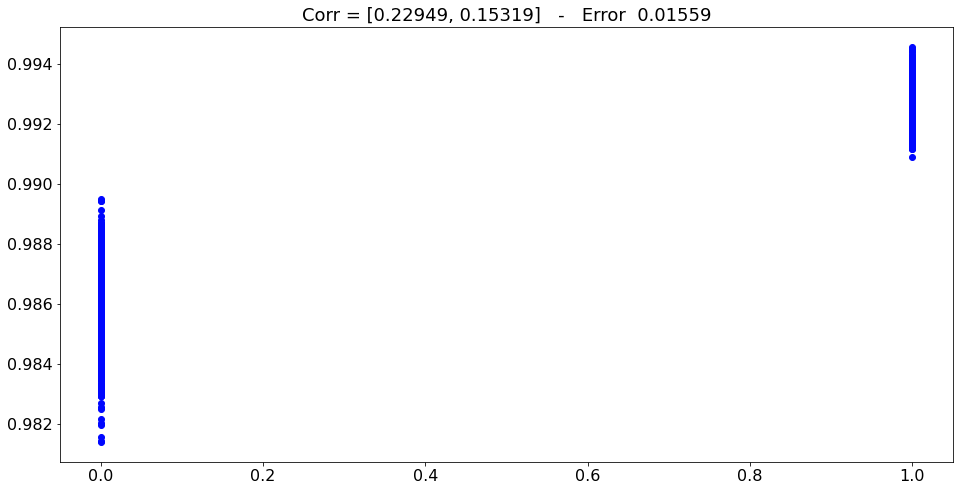

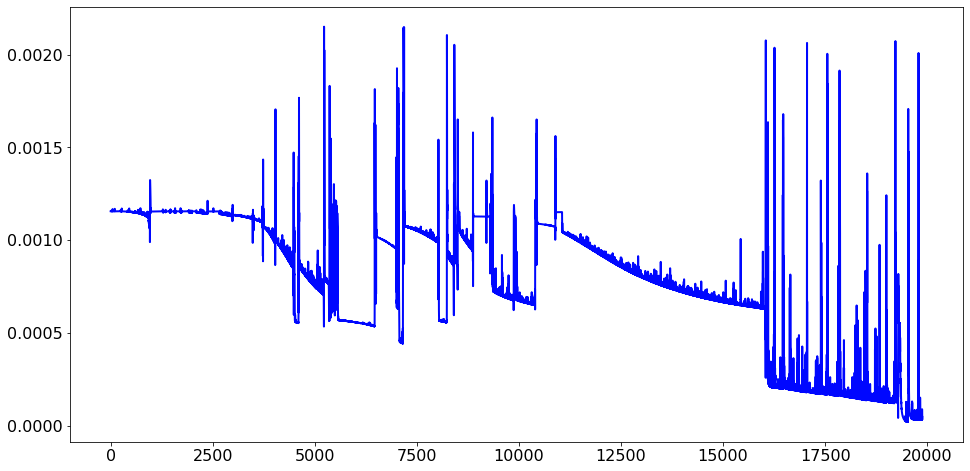

In [5]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #

## riprovo con la batchnorm per abbreviare il training - nei Linear layers, dopo la Relu 

In [4]:
config_file = "configurations/classification1.yml"
c = Config(config_file)
c.conf['model']['put_batchnorm'] = True
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()

<class 'str'>
Generating dataset...
Mean connectivity for each node: 14.943 p=0.05
Mean connectivity for each node: 29.897 p=0.1
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 30.12it/s]


Tempo impiegato: 66.61915135383606


  4%|█▊                                              | 743/20000 [03:44<1:37:06,  3.30it/s]

Early stopping!!!
test accuracy finale: 1.0


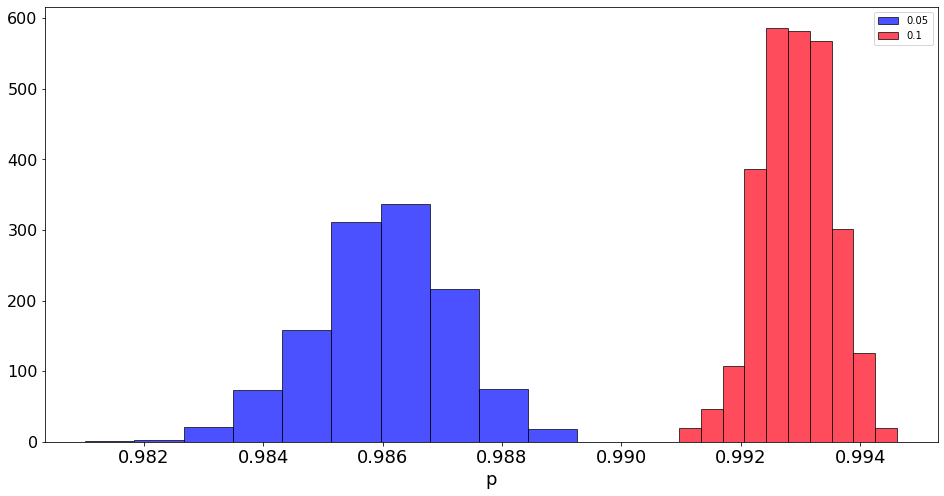

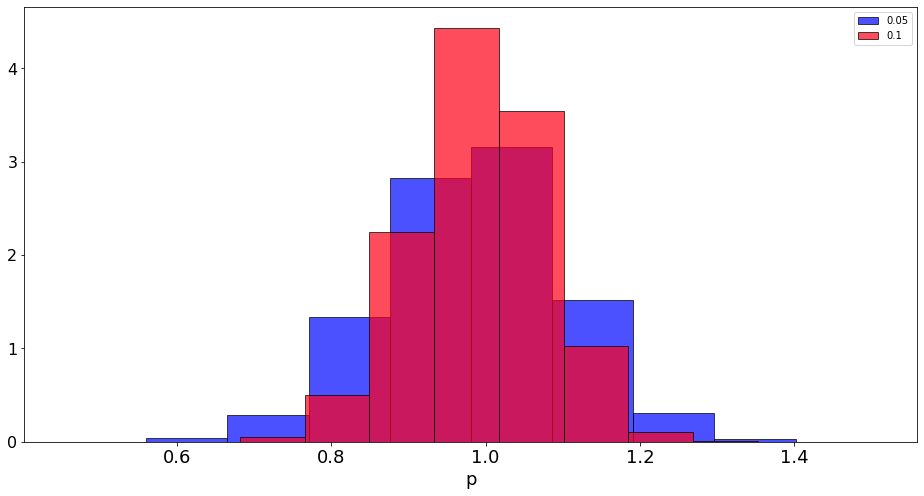

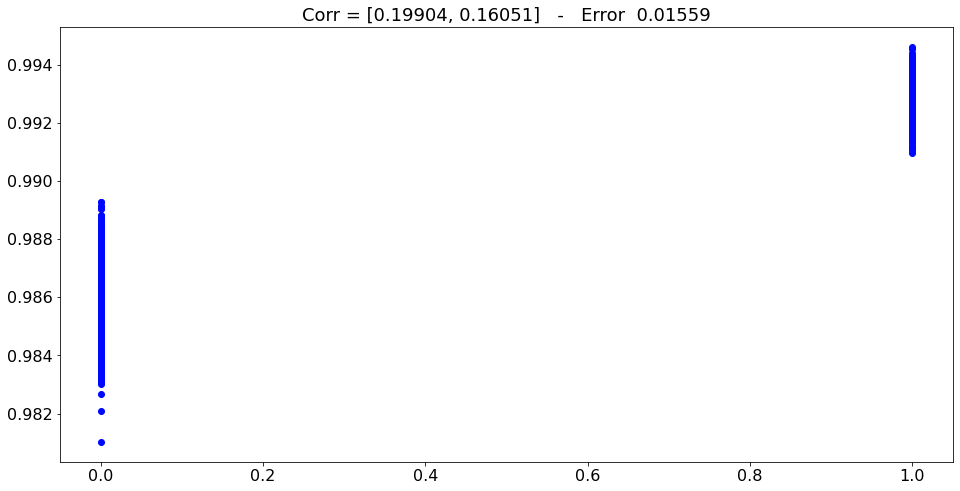

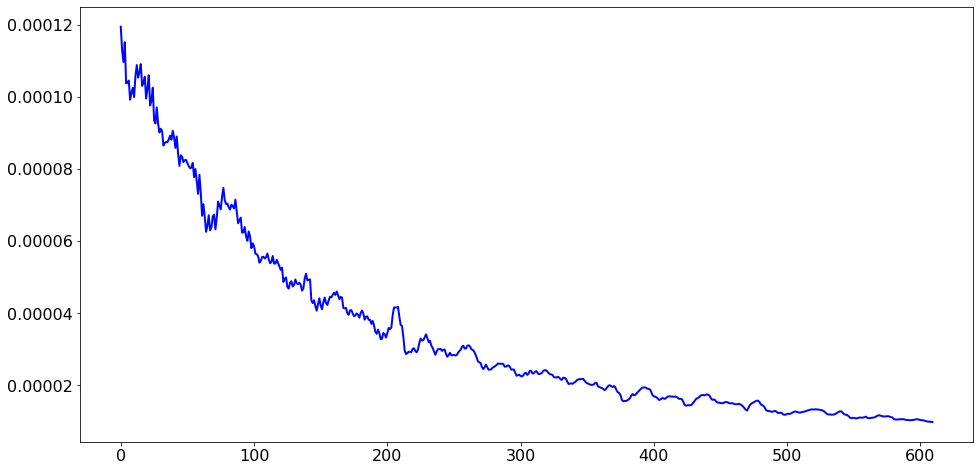

In [6]:
embedding_class = xp.embedding()
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #

#### Il training risulta di gran lungo più corto con il modo corretto di inserire la batchnormalization (prima era tra i layer conv)

## layer Linear - GCN trainable

In [2]:
config_file = "configurations/classification1.yml"
c = Config(config_file)
c.conf['model']['put_batchnorm'] = True    
c.conf['model']['freezeGCNlayers'] = False
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()

<class 'str'>
Generating dataset...
Mean connectivity for each node: 14.958 p=0.05
Mean connectivity for each node: 29.9 p=0.1
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.80it/s]


Tempo impiegato: 69.68445420265198


  3%|█▋                                              | 685/20000 [03:34<1:40:38,  3.20it/s]

Early stopping!!!
test accuracy finale: 0.9983333333333333


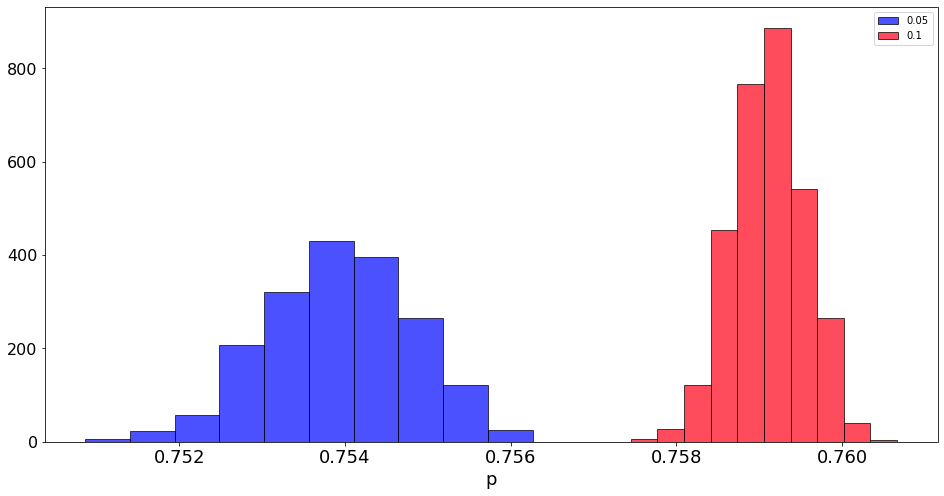

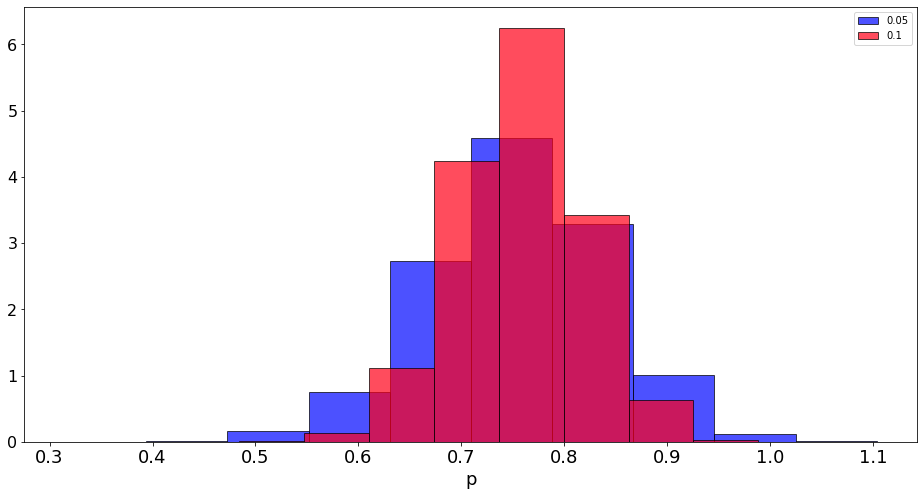

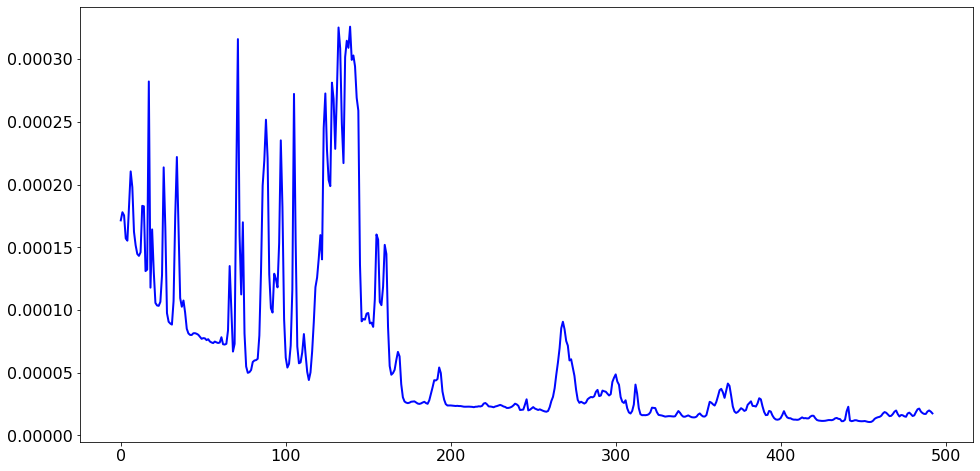

In [10]:
embedding_class = xp.embedding()
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #

## 3D

In [4]:
config_file = "configurations/classification1.yml"
c = Config(config_file)
c.conf['model']['put_batchnorm'] = True    
c.conf['model']['freezeGCNlayers'] = False
c.conf['model']['GCNneurons_per_layer'] = [1, 16, 16, 3]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 14.947 p=0.05
Mean connectivity for each node: 29.853 p=0.1
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.72it/s]


Tempo impiegato: 33.77126479148865


  5%|██▌                                              | 1054/20000 [03:09<56:47,  5.56it/s]


Early stopping!!!
test accuracy finale: 1.0


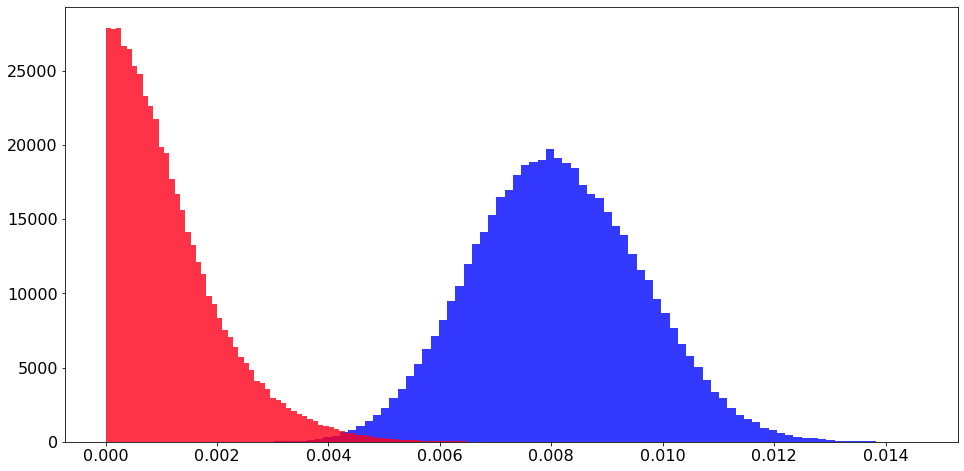

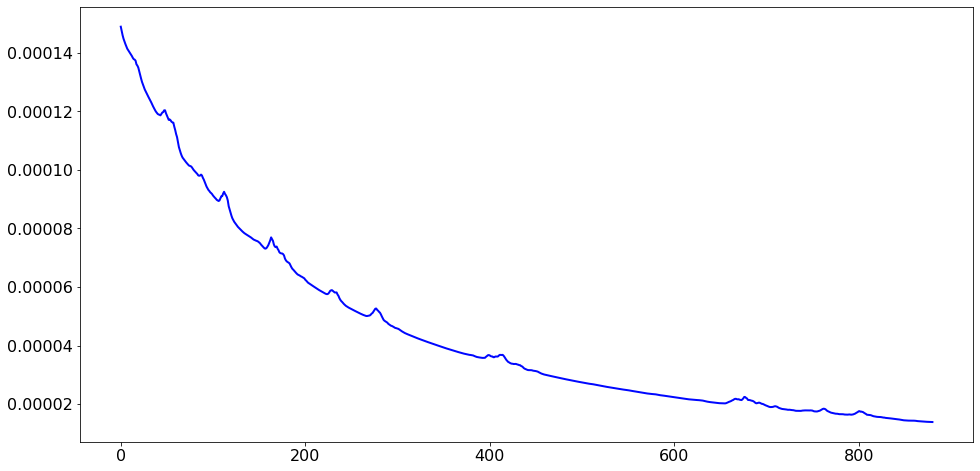

In [5]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #

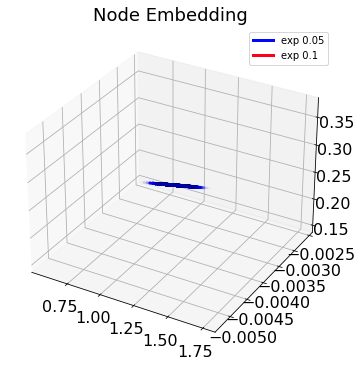

In [51]:
plot_node_emb_3D(embedding_class, xp.trainer.config_class)

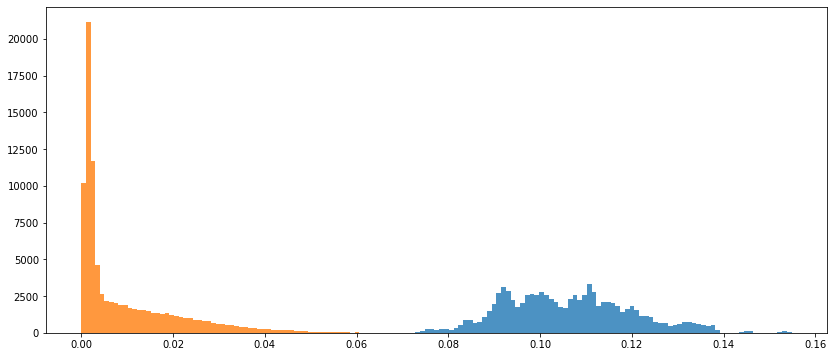

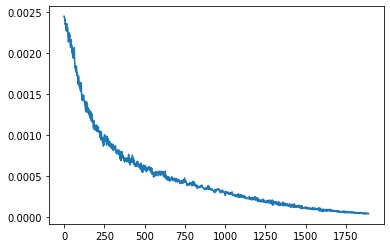

In [54]:
# vecchio

## senza ultimo layer Linear

In [2]:
config_file = "configurations/classification2.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 14.923 p=0.05
Mean connectivity for each node: 89.709 p=0.3
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████| 600/600 [00:42<00:00, 14.04it/s]


Tempo impiegato: 42.864259481430054


100%|█████████████████████████████████████████████████████████████████████| 2500/2500 [06:59<00:00,  5.96it/s]


test accuracy finale: 1.0


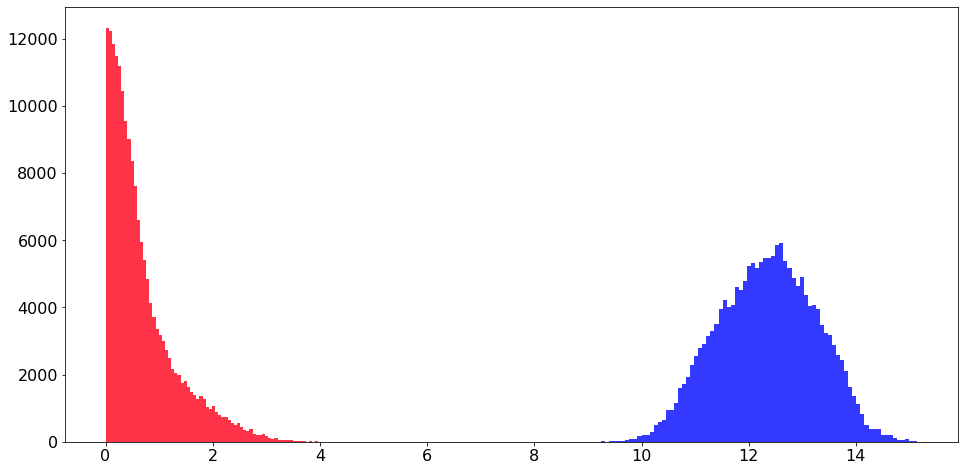

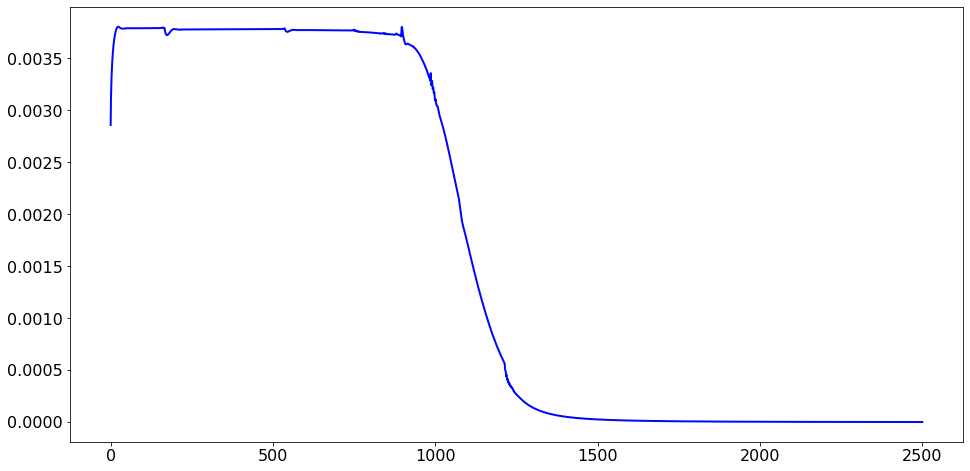

In [3]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons)
plt.plot(xp.trainer.test_loss_list);

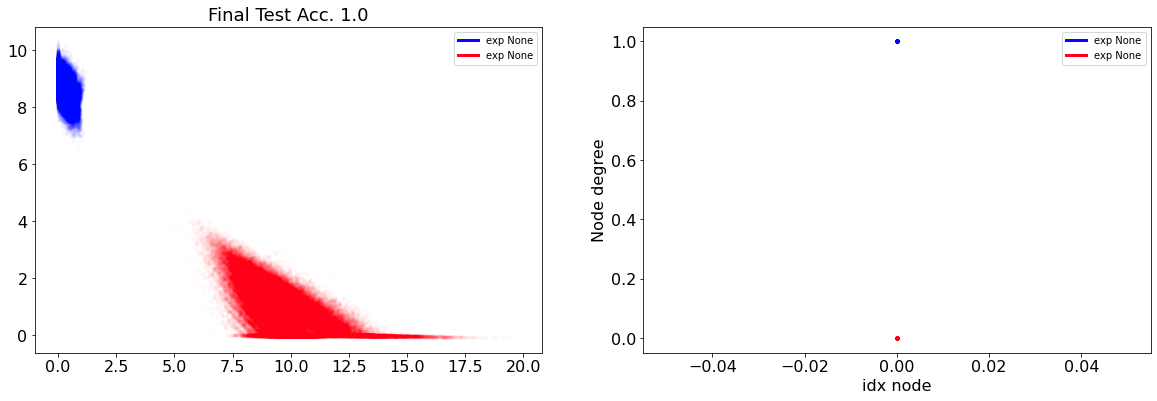

In [10]:
plot_node_emb_nD_perclass(embedding_class.node_emb_perclass)

## Più di due classi - senza Linear

In [2]:
config_file = "configurations/classification2.yml"  # -> classification_ER6class_19dic22.yml
c = Config(config_file)
#c.conf['model']['put_batchnorm'] = True    
#c.conf['model']['freezeGCNlayers'] = False
#c.conf['model']['GCNneurons_per_layer'] = [1, 16, 16, 3]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 9.973 p=0.05
Mean connectivity for each node: 19.938 p=0.1
Mean connectivity for each node: 59.725 p=0.3
Mean connectivity for each node: 79.604 p=0.4
Mean connectivity for each node: 99.438 p=0.5
Mean connectivity for each node: 119.412 p=0.6
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████| 1200/1200 [01:08<00:00, 17.52it/s]


Tempo impiegato: 68.69020581245422


100%|██████████████████████████████████████████████| 25000/25000 [1:42:29<00:00,  4.07it/s]


test accuracy finale: 0.9583333333333334


/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


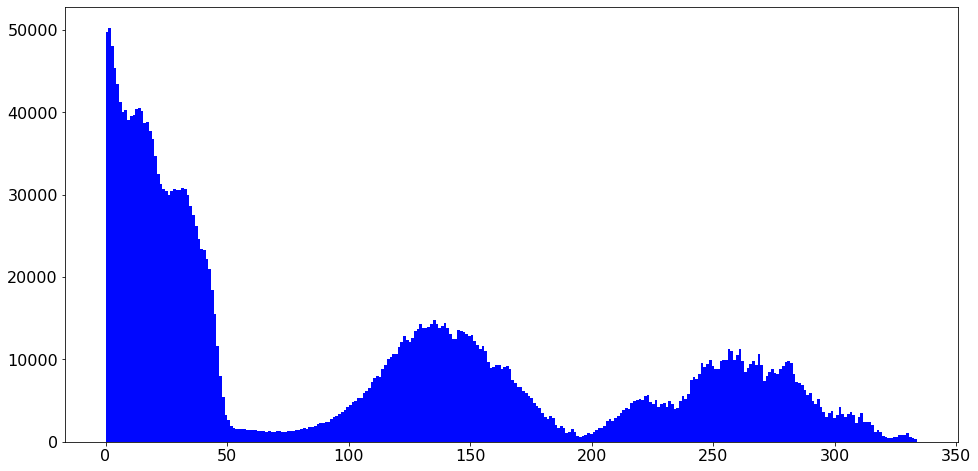

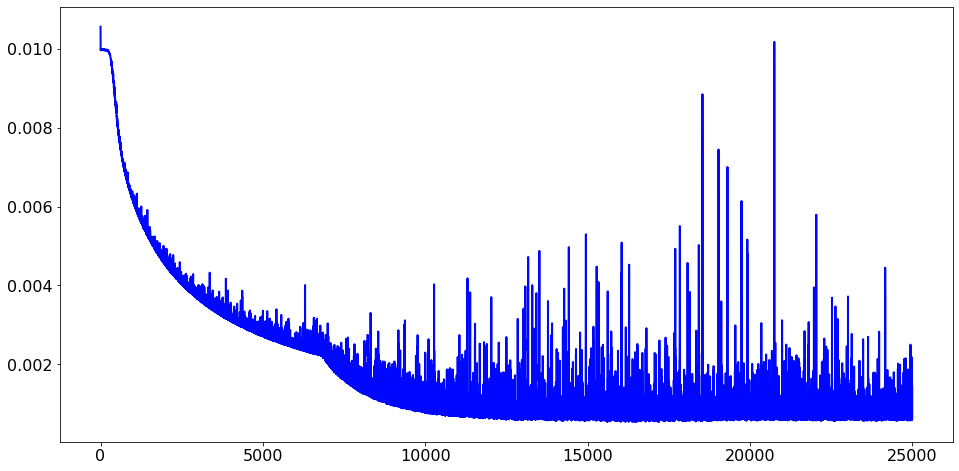

In [4]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)
plt.plot(xp.trainer.test_loss_list);  #array_wo_outliers

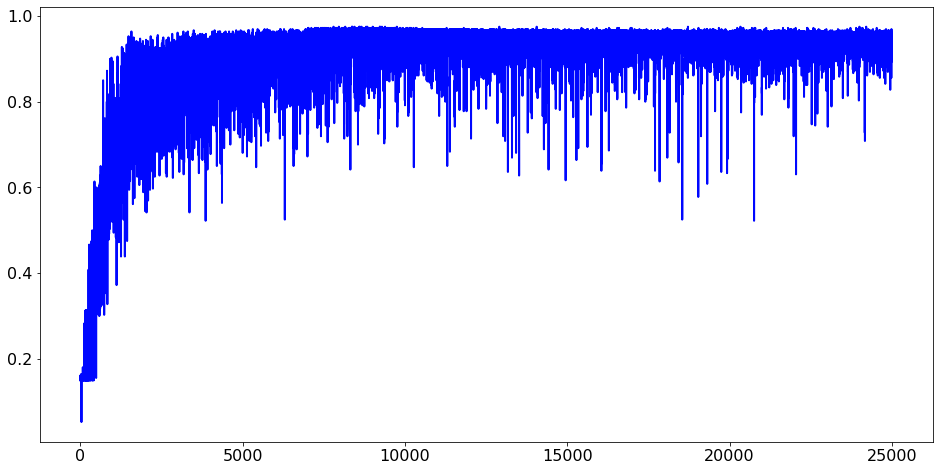

In [22]:
plt.plot(xp.trainer.accuracy_list)

In [19]:
# collegato al file cinfig classification_ER6class_19dic22.yml
with open('embedding_ER_6class_19dic22.pkl', 'wb') as file:
    pickle.dump(embedding_class, file, protocol=pickle.HIGHEST_PROTOCOL)
    

In [20]:
print(num_emb_neurons)
#xp.trainer.dataset

6


In [23]:
with open('test_loss_ER_6class_19dic22.pkl', 'wb') as file:
    pickle.dump(xp.trainer.test_loss_list, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('accuracy_ER_6class_19dic22.pkl', 'wb') as file:
    pickle.dump(xp.trainer.accuracy_list, file, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
single_labels = embedding_class.get_all_scalar_labels_per_class()

In [73]:
graphemb_perclass = np.array(embedding_class.get_all_graph_emb_per_class())
graphemb_perclass.shape

(6, 200, 6)

In [62]:
# intra distances
def calc_coppie_intracluster(graph_emb_cluster):
    NN = graph_emb_cluster.shape[0]
    coppie_numeric = list(itertools.combinations(range(NN), 2))
    coppie = graph_emb_cluster[coppie_numeric]
    #coppie_labels = le stesse per tutti
    distances = []
    for a, b in coppie:
        dist = np.linalg.norm(a-b)
        distances.append(dist)
    return distances


In [69]:
intra_dists = []
for i in range(len(graphemb_perclass)):
    intra_dists.append(calc_coppie_intracluster(graphemb_perclass[i]))

In [76]:
# inter distances
NN = len(graphemb_perclass)
coppie_classi = list(itertools.combinations(range(NN), 2))
coppie_gemb_perclass = [graphemb_perclass[c,:] for c in coppie_classi]

In [77]:
#embedding_class.emb_perclass[0][0].scalar_label
coppie_labels_class = [(embedding_class.emb_perclass[c[0]][0].scalar_label, embedding_class.emb_perclass[c[1]][0].scalar_label) for c in coppie_classi]

In [99]:
labels_str = [str(i).strip('(').strip(')').replace(',',' <->') for i in coppie_labels_class]

In [81]:
inter_dists_perclass = []
for cluster_a, cluster_b in coppie_gemb_perclass:
    inter_dists_ab = []
    NN = len(cluster_a)  # assumo sia la stessa per tutti i cluster
    coppie_ab = list(itertools.combinations(range(NN), 2))
    for ca, cb in coppie_ab:
        a = cluster_a[ca]
        b = cluster_b[cb]
        dist = np.linalg.norm(a-b)
        inter_dists_ab.append(dist)
    inter_dists_perclass.append(inter_dists_ab)
        

In [28]:
coppie_gemb_class[0].shape

(2, 200, 6)

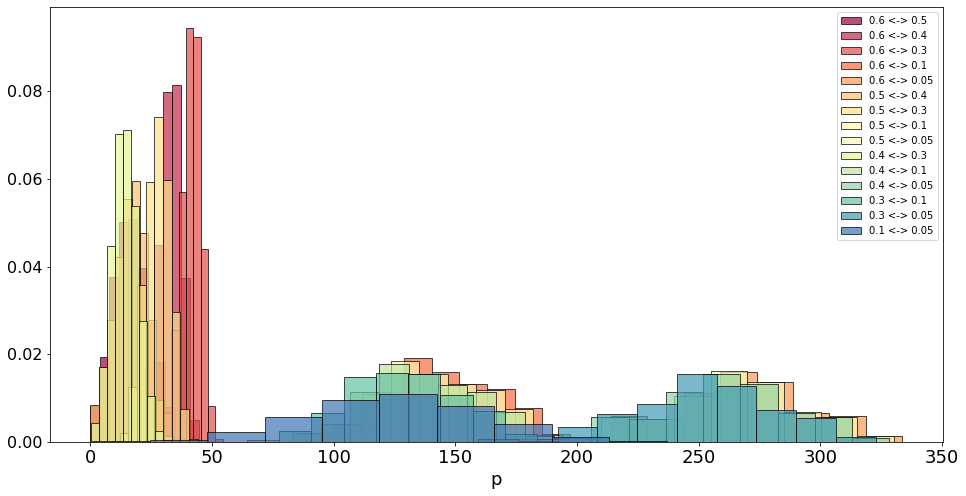

In [111]:
plot_dim1(inter_dists_perclass, want_kde=False, labels=labels_str)

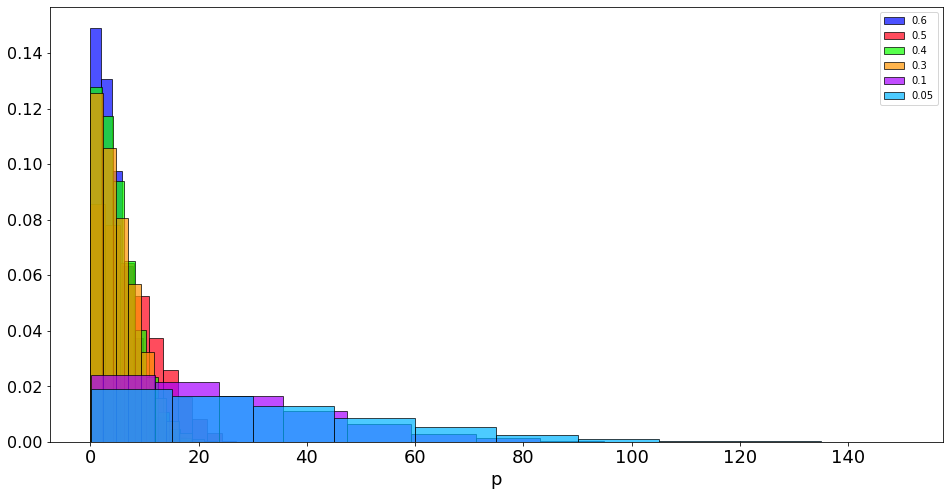

In [110]:
plot_dim1(intra_dists, want_kde=False, labels=single_labels)

## Più di due classi - con Linear

In [ ]:
config_file = "configurations/classification2.yml"  
c = Config(config_file)
#c.conf['model']['put_batchnorm'] = True    
#c.conf['model']['freezeGCNlayers'] = False
#c.conf['model']['GCNneurons_per_layer'] = [1, 16, 16, 3]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

In [5]:
embedding_class = xp.embedding()

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


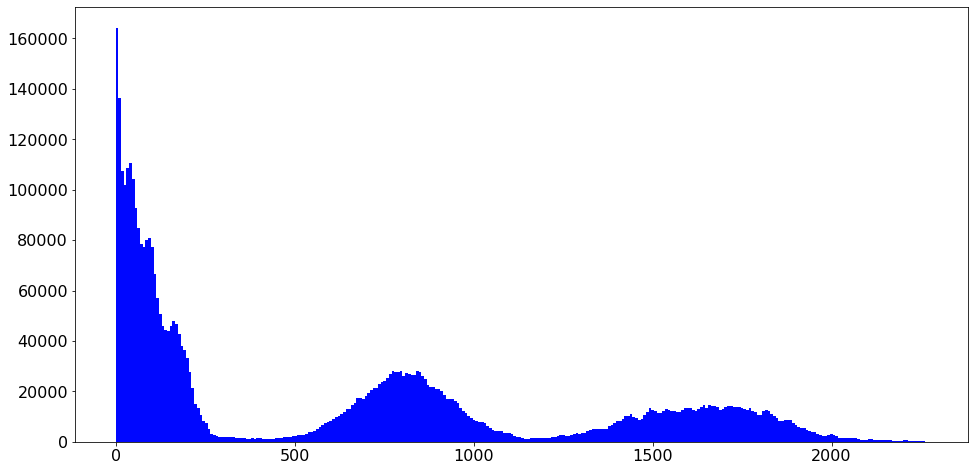

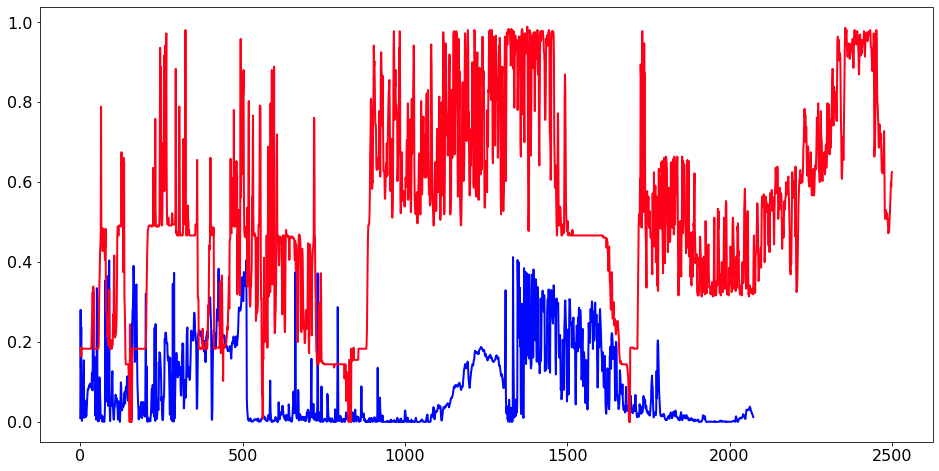

In [12]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #
plt.plot(xp.trainer.accuracy_list)

In [9]:
inter_dists_perclass, intra_dists_perclass, coppie_labels_class, single_labels = embedding_class.calc_coppie_multiclass()
labels_str = [str(i).strip('(').strip(')').replace(',',' <->') for i in coppie_labels_class]

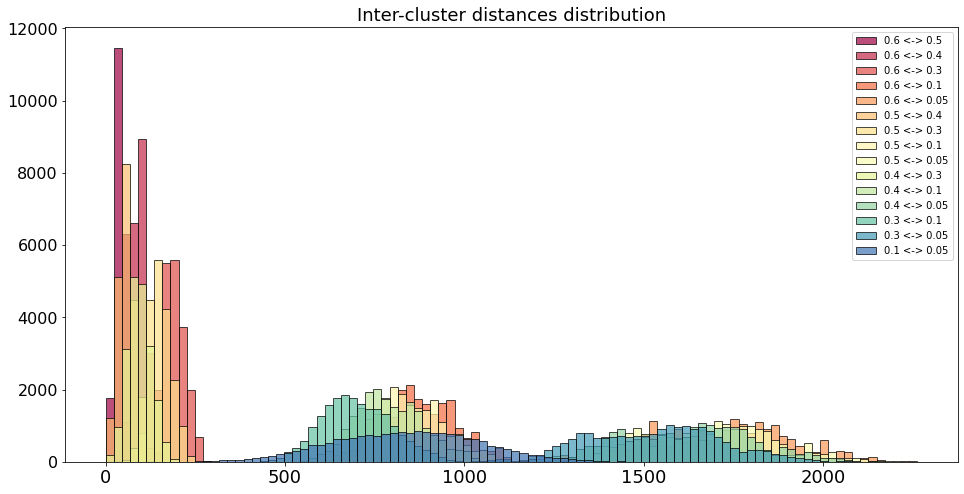

In [10]:
plot_dim1(inter_dists_perclass, bins=100, want_kde=False, density=False, labels=labels_str, title="Inter-cluster distances distribution")#, nomefile="inter_cluster_many_class.png")

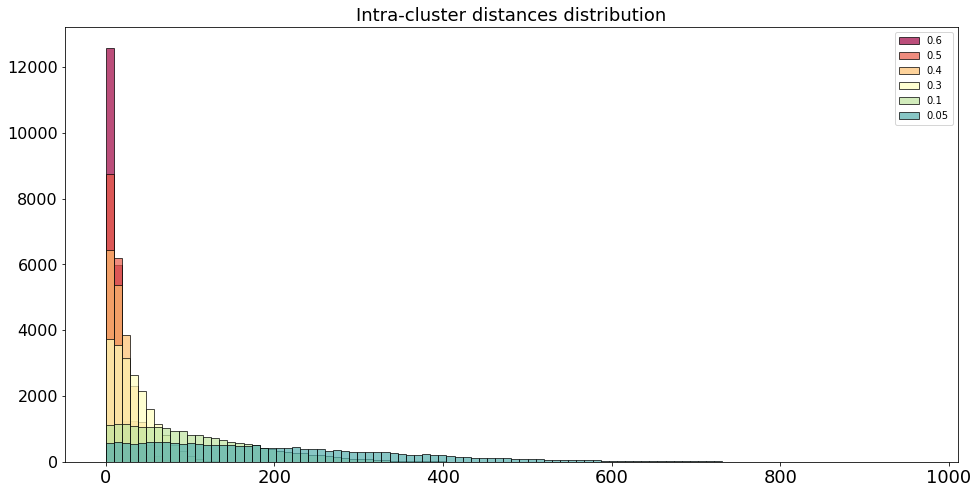

In [11]:
plot_dim1(intra_dists_perclass, bins=100, want_kde=False, density=False, labels=single_labels, title="Intra-cluster distances distribution")#, nomefile="intra_cluster_many_class.png")

## Più di due classi - con Linear  GCN freezed

In [14]:
config_file = "configurations/classification2.yml" 
c = Config(config_file)
c.conf['model']['freezeGCNlayers'] = True
#c.conf['model']['GCNneurons_per_layer'] = [1, 16, 16, 3]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 9.905 p=0.05
Mean connectivity for each node: 19.911 p=0.1
Mean connectivity for each node: 59.752 p=0.3
Mean connectivity for each node: 79.523 p=0.4
Mean connectivity for each node: 99.415 p=0.5
Mean connectivity for each node: 119.45 p=0.6
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [03:10<00:00,  6.31it/s]


Tempo impiegato: 190.29576778411865


  0%|                                                                                                 | 1/2500 [00:00<12:14,  3.40it/s]

0.009941289491123623


  0%|                                                                                                 | 2/2500 [00:00<12:10,  3.42it/s]

0.009935004843605889


  1%|█                                                                                               | 29/2500 [00:08<11:38,  3.54it/s]

0.009539723727438184


  1%|█▏                                                                                              | 30/2500 [00:08<11:42,  3.51it/s]

0.008446730838881599


  1%|█▎                                                                                              | 35/2500 [00:09<11:40,  3.52it/s]

0.007636330525080363


  2%|█▍                                                                                              | 38/2500 [00:10<11:39,  3.52it/s]

0.007012898723284404


  2%|█▍                                                                                              | 39/2500 [00:11<11:42,  3.50it/s]

0.0064828243520524765


  2%|█▋                                                                                              | 43/2500 [00:12<11:39,  3.51it/s]

0.00333187331755956


  2%|█▉                                                                                              | 52/2500 [00:14<11:31,  3.54it/s]

0.0029719108508692847


  2%|██                                                                                              | 55/2500 [00:15<11:29,  3.54it/s]

0.0029596282376183405


  3%|██▍                                                                                             | 64/2500 [00:18<11:26,  3.55it/s]

0.0017257670561472574


  3%|██▊                                                                                             | 74/2500 [00:20<11:20,  3.56it/s]

0.0010337669402360917


  3%|██▉                                                                                             | 77/2500 [00:21<11:24,  3.54it/s]

0.0007729903691344792


  4%|███▍                                                                                            | 88/2500 [00:24<11:15,  3.57it/s]

0.0007012183881468243


  4%|███▍                                                                                            | 89/2500 [00:25<11:21,  3.54it/s]

0.0006825191486212942


  4%|███▍                                                                                            | 90/2500 [00:25<11:24,  3.52it/s]

0.0006702886066502994


  4%|███▋                                                                                            | 96/2500 [00:26<11:19,  3.54it/s]

0.0005541691763533487


  4%|████                                                                                           | 106/2500 [00:29<11:10,  3.57it/s]

0.0005356600094172689


  4%|████                                                                                           | 107/2500 [00:30<11:16,  3.54it/s]

0.00044567111051744884


  6%|█████▎                                                                                         | 139/2500 [00:38<11:00,  3.57it/s]

0.0004301113076508045


  6%|█████▉                                                                                         | 156/2500 [00:43<10:55,  3.58it/s]

0.0004272020732363065


  6%|█████▉                                                                                         | 157/2500 [00:43<11:00,  3.55it/s]

0.000415045985331138


  8%|████████                                                                                       | 211/2500 [00:59<10:44,  3.55it/s]

0.00040370351117518215


  9%|████████▏                                                                                      | 215/2500 [01:00<10:43,  3.55it/s]

0.00040306840091943743


  9%|████████▉                                                                                      | 235/2500 [01:05<10:33,  3.58it/s]

0.0004012754807869593


 14%|█████████████▎                                                                                 | 351/2500 [01:37<10:03,  3.56it/s]

0.00039698278738392725


 19%|██████████████████▍                                                                            | 485/2500 [02:15<09:42,  3.46it/s]

0.00038983200987180076


 20%|███████████████████                                                                            | 503/2500 [02:21<09:33,  3.48it/s]

0.00038493158709671763


 76%|███████████████████████████████████████████████████████████████████████▌                      | 1903/2500 [08:59<02:54,  3.43it/s]

0.00038470407533976766


 96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 2390/2500 [11:16<00:30,  3.57it/s]

0.00038218175371487935


 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 2439/2500 [11:30<00:17,  3.49it/s]

0.00038097379729151726


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [11:48<00:00,  3.53it/s]


test accuracy finale: 0.9305555555555556


/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


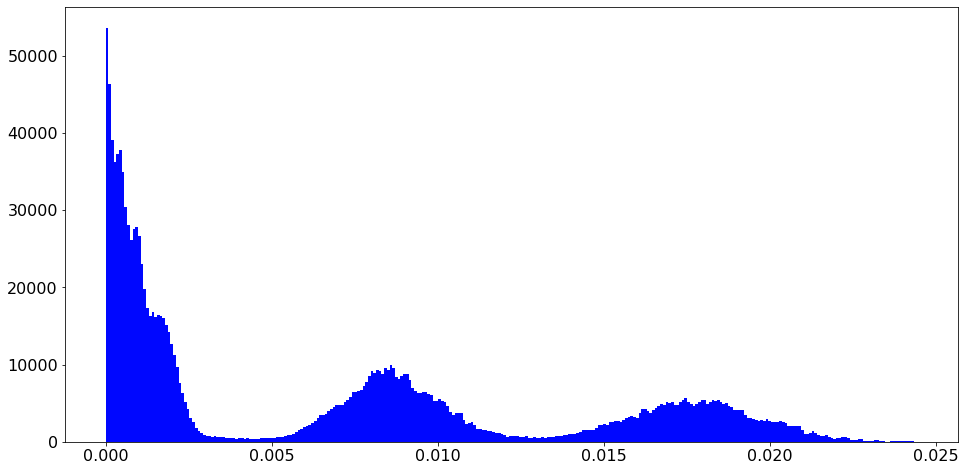

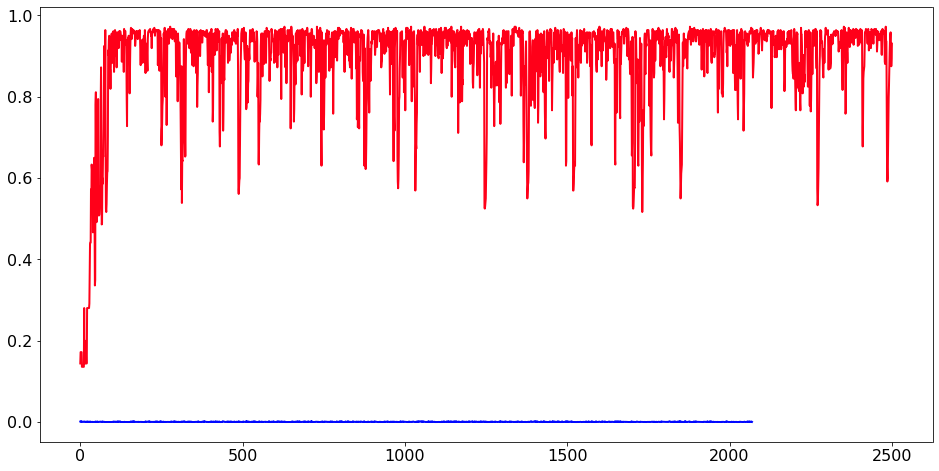

In [15]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)

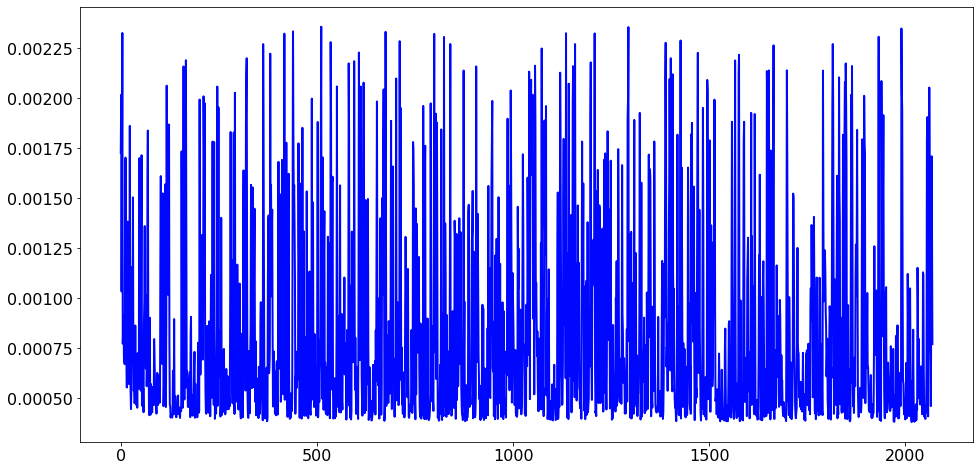

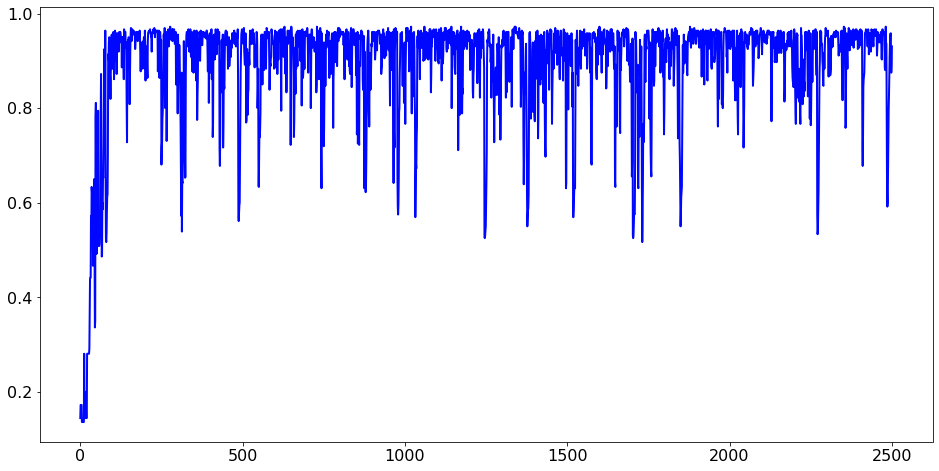

In [17]:
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #
plt.show()
plt.plot(xp.trainer.accuracy_list)

In [18]:
inter_dists_perclass, intra_dists_perclass, coppie_labels_class, single_labels = embedding_class.calc_coppie_multiclass()
labels_str = [str(i).strip('(').strip(')').replace(',',' <->') for i in coppie_labels_class]

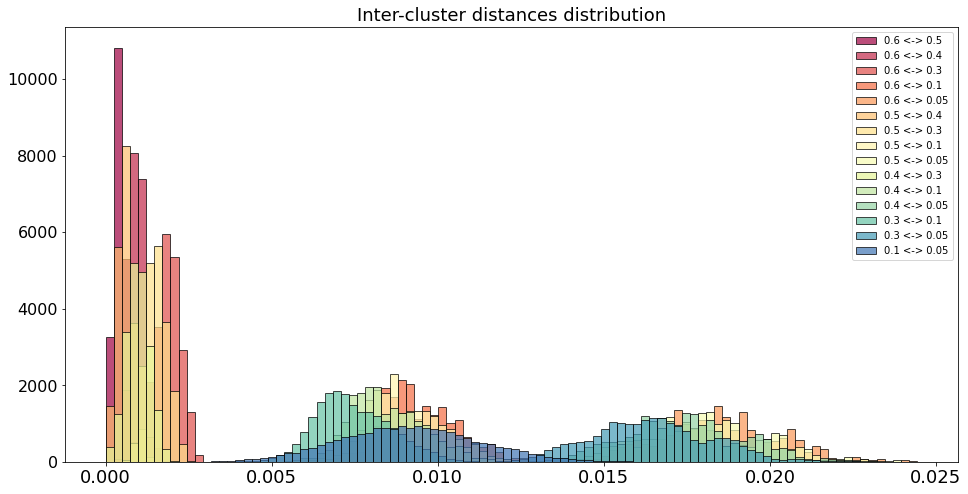

In [19]:
plot_dim1(inter_dists_perclass, bins=100, want_kde=False, density=False, labels=labels_str, title="Inter-cluster distances distribution")#, nomefile="inter_cluster_many_class.png")

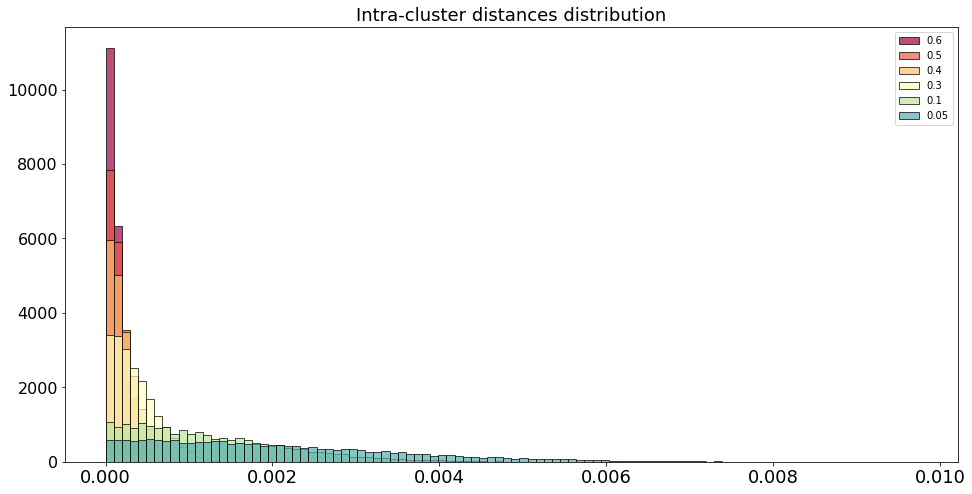

In [20]:
plot_dim1(intra_dists_perclass, bins=100, want_kde=False, density=False, labels=single_labels, title="Intra-cluster distances distribution")#, nomefile="intra_cluster_many_class.png")

## many classes - 1D - con Linear - freezed

In [21]:
config_file = "configurations/classification2.yml"  
c = Config(config_file)
c.conf['model']['freezeGCNlayers'] = True
c.conf['model']['GCNneurons_per_layer'] = [1, 16, 16, 1]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 9.964 p=0.05
Mean connectivity for each node: 19.868 p=0.1
Mean connectivity for each node: 59.722 p=0.3
Mean connectivity for each node: 79.477 p=0.4
Mean connectivity for each node: 99.526 p=0.5
Mean connectivity for each node: 119.273 p=0.6
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [03:09<00:00,  6.33it/s]


Tempo impiegato: 189.94112586975098


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [07:04<00:00,  3.53it/s]


test accuracy finale: 0.9638888888888889


/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


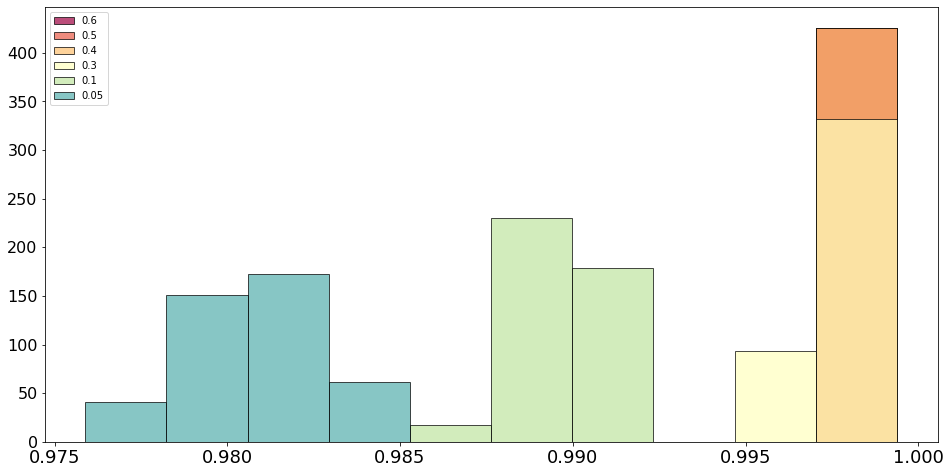

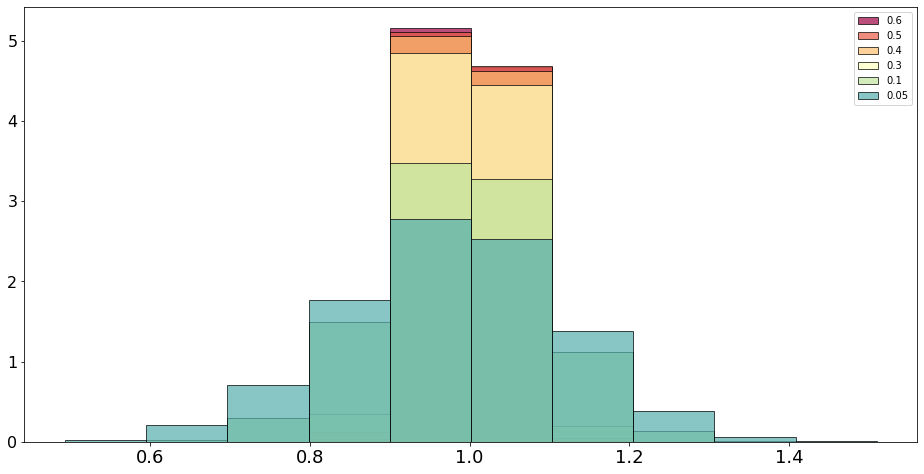

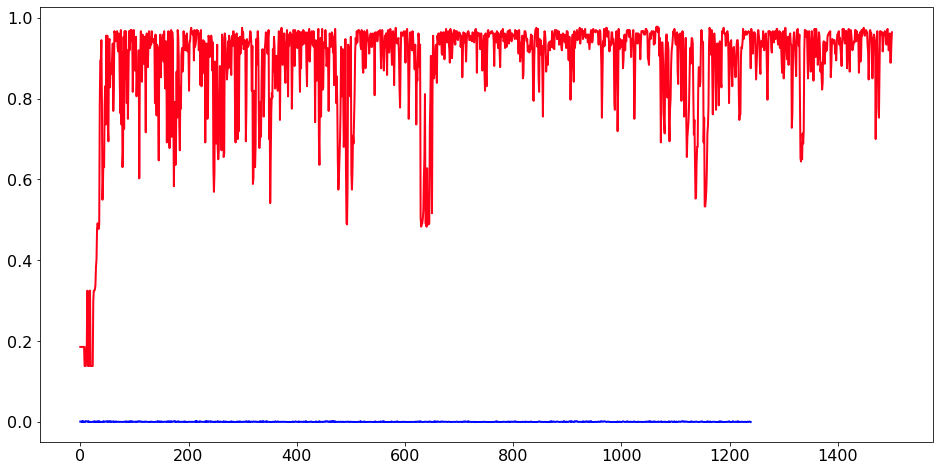

In [24]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)
plt.plot(array_wo_outliers(xp.trainer.test_loss_list));  #
plt.plot(xp.trainer.accuracy_list)

In [ ]:
config['graph_dataset']['list_p'] = [0.03, 0.2]
dataset_grafi_nx, dataset_labels, list_p = dataset_nclass_ER(config)
trainer.load_dataset(dataset_grafi_nx, dataset_labels)
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.bs, shuffle=False) 
embeddings_array2 = trainer.take_embedding(all_data_loader)
embeddings_array2 = np.array([emb.cpu().detach().numpy() for emb in embeddings_array2])

embeddings2 = Embedding(embeddings_array2, trainer.dataset.dataset, trainer.dataset.labels, list_p)

In [ ]:
plt.figure(figsize=(18, 4))
h,e = np.histogram(embeddings2.embeddings_array.flatten(), bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

In [ ]:
actual_p2 = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings2.embedding_labels, 0.15)).flatten()
    plt.scatter(actual_p2[mask_int], embeddings2.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings2.embeddings_array[mask_int].flatten(), actual_p2[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()

# Configuration model con grafi power law

# Classification

In [2]:
rootsave = Path("output_plots/")
config_file = "configurations/classification_cm.yml"

In [5]:
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
node_embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 48.61it/s]


Tempo impiegato: 8.27750015258789


 48%|█████████████████████████████████████████████▌                                                 | 719/1500 [02:21<02:33,  5.08it/s]

Early stopping!!!
test accuracy finale: 1.0


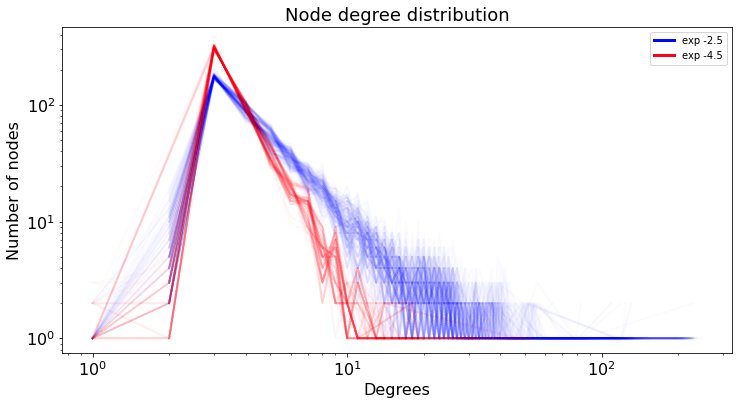

In [7]:
plot_data_degree_sequence(xp.trainer.config_class, node_embedding_class.emb_perclass)

In [27]:
len(node_embedding_class.emb_perclass[0])

200

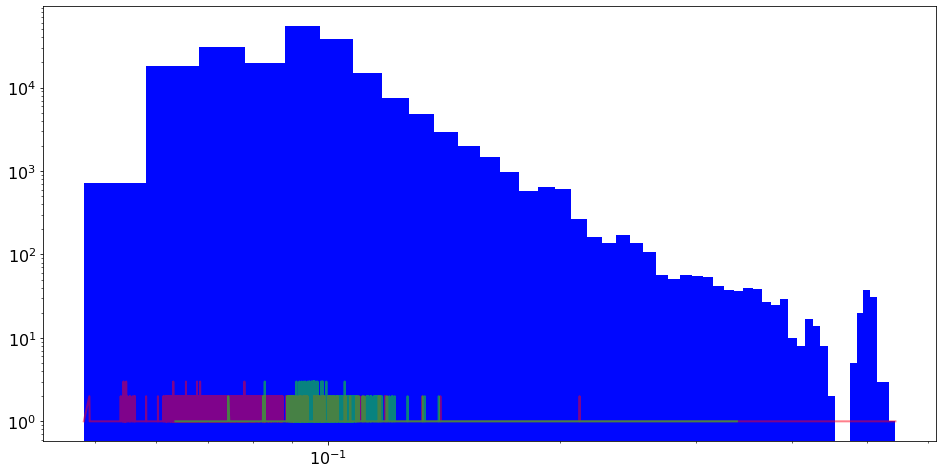

In [21]:
plt.hist(node_embedding_class.node_embedding_array, bins=50);
for emb_pergraph in node_embedding_class.emb_perclass:
    counts = np.unique([n.node_embedding_array for n in emb_pergraph], return_counts=True)
        #plt.loglog(*counts, c=color, alpha=alpha_value, label=emb_pergraph.exponent, linewidth=3)
    plt.loglog(*counts, alpha=0.5)#, label=emb_pergraph.exponent)

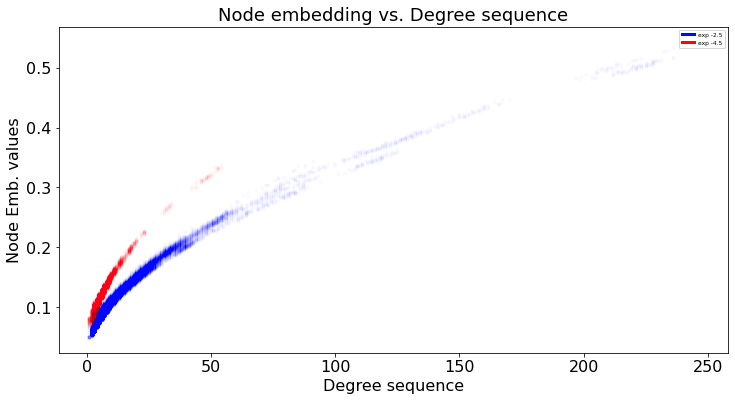

In [11]:
fname = rootsave / Path("powerlaw/scatter_node_emb_2class_freezed.png")
scatter_node_emb(node_embedding_class.emb_perclass, xp.trainer.config_class, sequential_colors=False, filename=fname)

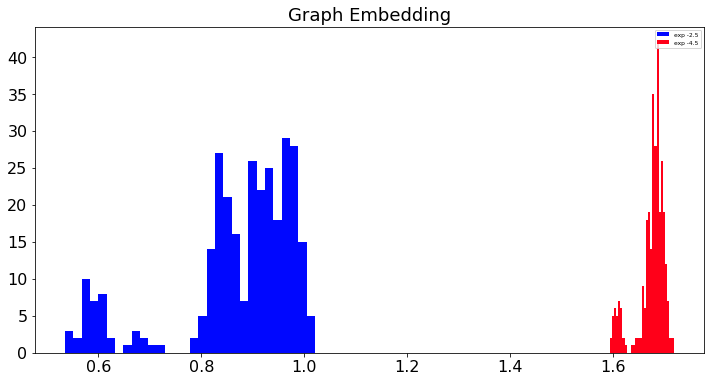

In [8]:
plot_graph_emb_1D(node_embedding_class.node_emb_perclass, xp.trainer.config_class)

### imposto la dimensione di embedding a 2

In [16]:
c = Config(config_file)
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 16, 2] 

xp1 = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp1.just_train()
node_embedding_class1 = xp1.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.07it/s]


Tempo impiegato: 18.208189964294434


 18%|█████████████▌                                                               | 88/500 [00:33<02:34,  2.66it/s]


test accuracy finale: 1.0


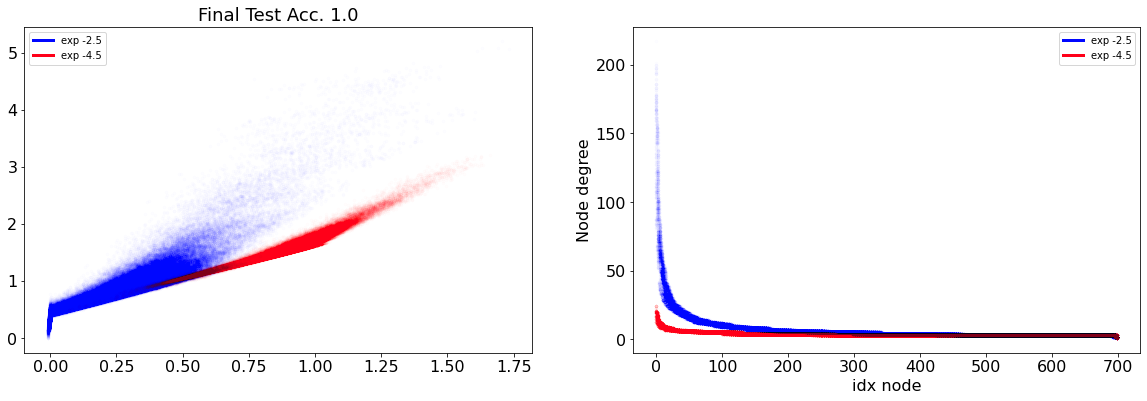

In [17]:
plot_node_emb_nD_perclass(node_embedding_class1.node_emb_perclass, xp1.trainer.last_accuracy, xp1.trainer.config_class)

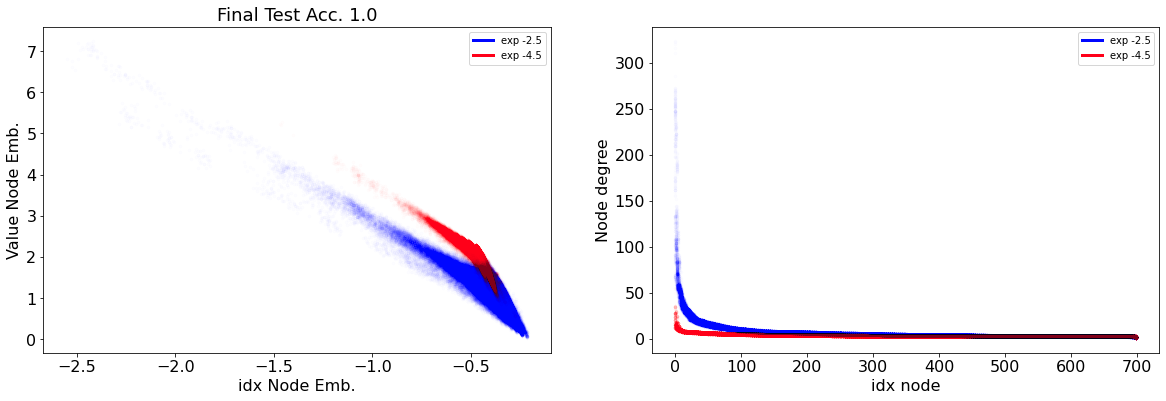

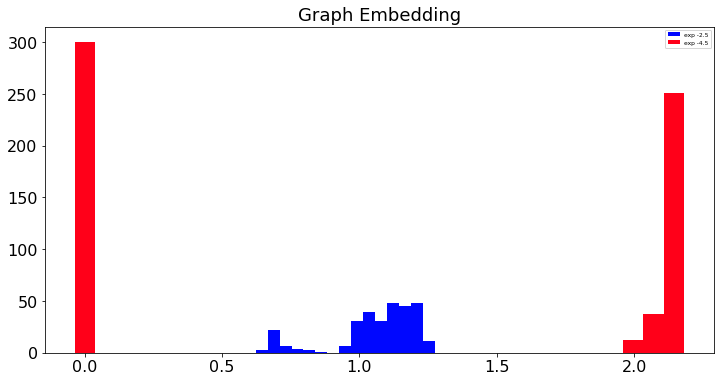

In [57]:
plot_graph_emb_1D(node_embedding_class1.node_emb_perclass, xp1.trainer.config_class)

### ripeto con gcn layer freezed

In [4]:
c = Config(config_file)
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 16, 2]
c.conf['model']['freezeGCNlayers'] = True

xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
node_embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 31.85it/s]


Tempo impiegato: 18.91915512084961


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


test accuracy finale: 1.0


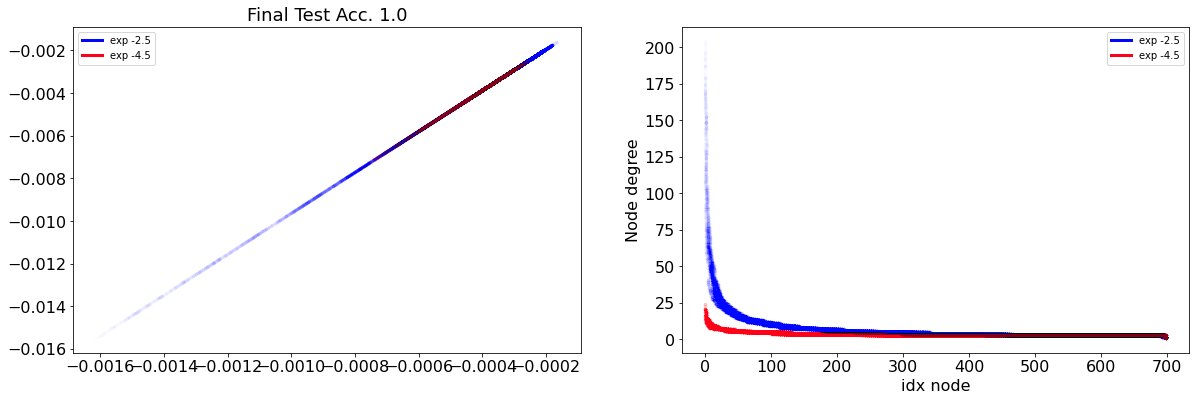

In [5]:
plot_node_emb_nD_perclass(node_embedding_class.node_emb_perclass, xp.trainer.last_accuracy, xp.trainer.config_class)

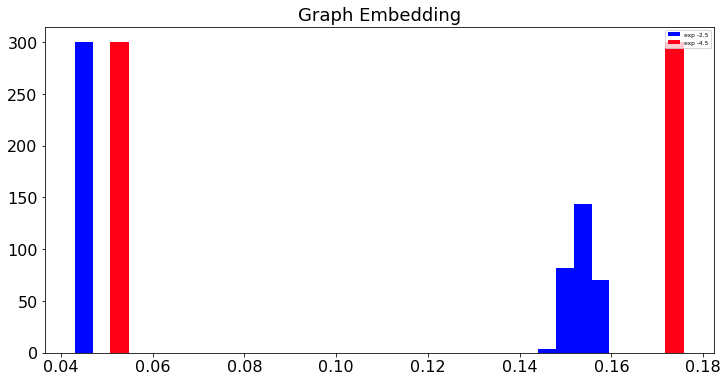

In [7]:
plot_graph_emb_1D(node_embedding_class.node_emb_perclass, xp.trainer.config_class)

### Dimensionality

In [6]:
#graph_embeddings_array1, node_embeddings_array, node_embeddings_array_id, final_output = xp1.trainer.take_embedding_all_data()

In [7]:
import skdim


In [8]:
danco = skdim.id.DANCo().fit(node_embeddings_array)

In [9]:
danco.dimension_

nan

In [18]:
def single_class_embedding(node_embedding_class, n):
    embclass = []
    for e in node_embedding_class.node_emb_perclass[n]:
        embclass.extend([e.node_embedding_array ])
    return embclass

In [11]:
data=np.array(embclass1).reshape(-1,2)

In [12]:
danco = skdim.id.DANCo().fit(data)

In [13]:
danco.dimension_

nan

In [14]:
lpca = skdim.id.lPCA().fit_pw(data, n_neighbors = 100, n_jobs = 16)

In [15]:
np.mean(lpca.dimension_pw_)

1.0

### trainable GCN

In [31]:
embclass0 = single_class_embedding(node_embedding_class1, 0)
embclass1 = single_class_embedding(node_embedding_class1, 1)

In [32]:
data0 = np.array(embclass0).reshape(-1,2)
lpca0 = skdim.id.lPCA().fit_pw(data0, n_neighbors = 100, n_jobs = 16)

data1 = np.array(embclass1).reshape(-1,2)
lpca1 = skdim.id.lPCA().fit_pw(data1, n_neighbors = 100, n_jobs = 16)

In [33]:
np.mean(lpca0.dimension_pw_), np.mean(lpca1.dimension_pw_)

(2.0, 2.0)

In [28]:
danco = skdim.id.DANCo().fit(data0)

In [30]:
danco.dimension_

nan

### imposto la dimensione a 3

In [5]:
c = Config(config_file)
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 16, 3] 

xp3 = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp3.just_train()
node_embedding_class3 = xp3.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.36it/s]


Tempo impiegato: 18.610315561294556


 29%|█████████████████████▉                                                      | 144/500 [00:52<02:09,  2.75it/s]


test accuracy finale: 1.0


In [11]:
%matplotlib inline

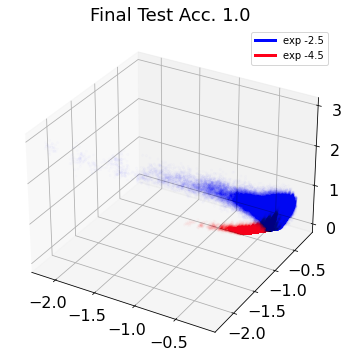

In [12]:
plot_node_emb_3D_perclass(node_embedding_class3.node_emb_perclass, xp3.trainer.last_accuracy, xp3.trainer.config_class)

In [ ]:
Rigiro scikit_dimension anche in 3D